# Flatiron Health aNSCLC: Strict trials with GBM crude 

***OBJECTIVE:*** **Inclusion criteria for trials in other notebooks were relaxed to allow for as many patients to be included as reasonably possible. In this notebook, inclusion criteria for the trials will be followed as closely as possible. Patients included in our trials will next be risk stratified using the gradient boosted model with crude imputation into 1 of 3 risk groups: high (top tertile), medium (middle tertile), and low (bottom tertile). Inverse-probability treatment weighted survival analysis will then be performed across these risk groups to get real-world estimates of survival while adjusting for measured confounders.** 
** 

***OUTLINE:***
1. **Identify patients with exclusion criteria:**
* Autoimmune diseases in the year preceding metastatic diagnosis  
* Other relevant comorbidities in the year preceding metastatic diagnosis  
* CNS metastasis at start of treatment 
* ECOG 2, 3, or 4 at start of treatment 
* Organ dysfunction at time of treatment 

2. **In silico trials:**
* KEYNOTE-042 
* KEYNOTE-024
* KEYNOTE-189 
* CHECKMATE-078
* FLAURA

## Part 1: Identify patients with exclusion criteria

In [1]:
import numpy as np
import pandas as pd

In [2]:
# Function that returns number of rows and count of unique PatientIDs for a dataframe. 
def row_ID(dataframe):
    row = dataframe.shape[0]
    ID = dataframe['PatientID'].nunique()
    return row, ID

In [3]:
train = pd.read_csv('train_full.csv')
row_ID(train)

(54786, 54786)

In [4]:
test = pd.read_csv('test_full.csv')
row_ID(test)

(13697, 13697)

In [5]:
df = pd.concat([train, test], ignore_index = True)
row_ID(df)

(68483, 68483)

### 1. Autoimmune diseases in the year preceding advanced diagnosis 
* Type 1 diabetes
* Rheumatoid arthritis
* Lupus
* Systemic sclerosis 
* Dermatomyositis
* Polymyositis
* Crohn's disease
* Ulcerative colitis 
* Psoriasis 
* Multiple sclerosis 

In [6]:
diagnosis = pd.read_csv('Diagnosis.csv')

In [7]:
diagnosis = diagnosis[diagnosis['PatientID'].isin(df['PatientID'])]       

In [8]:
diagnosis.loc[:, 'DiagnosisDate'] = pd.to_datetime(diagnosis['DiagnosisDate'])

In [9]:
enhanced_adv = pd.read_csv('Enhanced_AdvancedNSCLC.csv', low_memory = False)

In [10]:
enhanced_adv.loc[:, 'AdvancedDiagnosisDate'] = pd.to_datetime(enhanced_adv['AdvancedDiagnosisDate'])

In [11]:
row_ID(diagnosis)

(1499292, 68483)

In [12]:
diagnosis = pd.merge(diagnosis, enhanced_adv[['PatientID', 'AdvancedDiagnosisDate']], on = 'PatientID', how = 'left')

In [13]:
row_ID(diagnosis)

(1499292, 68483)

In [14]:
diagnosis.loc[:, 'date_diff'] = (diagnosis['DiagnosisDate'] - diagnosis['AdvancedDiagnosisDate']).dt.days

In [15]:
diagnosis.loc[:, 'diagnosis_code'] = diagnosis['DiagnosisCode'].replace('\.', '', regex = True)

In [16]:
# ICD-9 dataframe with unique codes for each patient. 
diagnosis_9 = (
    diagnosis
    .query('date_diff <= 0 and date_diff > -365')
    .query('DiagnosisCodeSystem == "ICD-9-CM"')
    .drop_duplicates(subset = (['PatientID', 'DiagnosisCode']), keep = 'first')
    .filter(items = ['PatientID', 'DiagnosisCode', 'diagnosis_code'])
)

In [17]:
auto_ID_9 = (
    diagnosis_9[diagnosis_9['diagnosis_code'].str.match('250(0[13]|1[13]|2[13]|3[13]|4[13]|5[13]|6[13]|7[13]|8[13]|9[13])|'
                                                        '714|'
                                                        '710[0134]|'
                                                        '55[56]|'
                                                        '696|'
                                                        '340')].PatientID.unique())

In [18]:
len(auto_ID_9)

87

In [19]:
# ICD-9 dataframe with unique codes for each patient. 
diagnosis_10 = (
    diagnosis
    .query('date_diff <= 0 and date_diff > -365')
    .query('DiagnosisCodeSystem == "ICD-10-CM"')
    .drop_duplicates(subset = (['PatientID', 'DiagnosisCode']), keep = 'first')
    .filter(items = ['PatientID', 'DiagnosisCode', 'diagnosis_code'])
)

In [20]:
auto_ID_10 = (
    diagnosis_10[diagnosis_10['diagnosis_code'].str.match('E10|'
                                                          'M05|'
                                                          'M32|'
                                                          'M33|'
                                                          'M34|'
                                                          'K50|'
                                                          'K51|'
                                                          'L40|'
                                                          'G35')].PatientID.unique())

In [21]:
len(auto_ID_10)

238

In [22]:
auto_IDs = np.unique(np.concatenate([auto_ID_9, auto_ID_10]))

In [23]:
len(auto_IDs)

322

### 2. Other relevant comorbidities in the year preceding advanced diagnosis 
* Interstitial lung disease 
* HIV
* Hep C
* Hep B
* Psychosis and other significant psychiatric disorders 
* Drug use disorders

In [24]:
other_comorb_9 = (
    diagnosis_9[diagnosis_9['diagnosis_code'].str.match('516|'
                                                        '042|'
                                                        '070[234567]|'
                                                        '29[5789]|'
                                                        '30[34]')].PatientID.unique())

In [25]:
len(other_comorb_9)

69

In [26]:
other_comorb_10 = (
    diagnosis_10[diagnosis_10['diagnosis_code'].str.match('J84|'
                                                          'B20|'
                                                          'B18|'
                                                          'F2[024589]|'
                                                          'F1[0145]')].PatientID.unique())

In [27]:
len(other_comorb_10)

474

In [28]:
other_comorb_IDs = np.unique(np.concatenate([other_comorb_9, other_comorb_10]))

In [29]:
len(other_comorb_IDs)

537

### 3. CNS metastasis at start of treatment 

#### First line treatment

In [30]:
line_therapy = pd.read_csv('LineOfTherapy.csv')

In [31]:
line_therapy = line_therapy[line_therapy['PatientID'].isin(df['PatientID'])]       

In [32]:
line_therapy.loc[:, 'StartDate'] = pd.to_datetime(line_therapy['StartDate'])

In [33]:
therapy_fl = line_therapy.query('LineNumber == 1').query('IsMaintenanceTherapy == False')[['PatientID', 'StartDate']]

In [34]:
row_ID(diagnosis)

(1499292, 68483)

In [35]:
cns_fl = pd.merge(diagnosis, therapy_fl, on = 'PatientID', how = 'left')

In [36]:
row_ID(diagnosis)

(1499292, 68483)

In [37]:
cns_fl.loc[:, 'fl_date_diff'] = (cns_fl['DiagnosisDate'] - cns_fl['StartDate']).dt.days

In [38]:
# ICD-9 dataframe with unique codes for each patient. 
cns_fl_9 = (
    cns_fl
    .query('fl_date_diff <= 0 and fl_date_diff > -90')
    .query('DiagnosisCodeSystem == "ICD-9-CM"')
    .drop_duplicates(subset = (['PatientID', 'DiagnosisCode']), keep = 'first')
    .filter(items = ['PatientID', 'DiagnosisCode', 'diagnosis_code'])
)

In [39]:
cns_fl_9_ids = (
    cns_fl_9[cns_fl_9['diagnosis_code'].str.match('198[34]')].PatientID.unique()
)

In [40]:
len(cns_fl_9_ids)

1065

In [41]:
# ICD-9 dataframe with unique codes for each patient. 
cns_fl_10 = (
    cns_fl
    .query('fl_date_diff <= 0 and fl_date_diff > -90')
    .query('DiagnosisCodeSystem == "ICD-10-CM"')
    .drop_duplicates(subset = (['PatientID', 'DiagnosisCode']), keep = 'first')
    .filter(items = ['PatientID', 'DiagnosisCode', 'diagnosis_code'])
)

In [42]:
cns_fl_10_ids = (
    cns_fl_10[cns_fl_10['diagnosis_code'].str.match('C79[34]')].PatientID.unique()
)

In [43]:
len(cns_fl_10_ids)

2829

In [44]:
cns_fl_IDs = np.unique(np.concatenate([cns_fl_9_ids, cns_fl_10_ids]))

In [45]:
len(cns_fl_IDs)

3876

#### Second line treatment

In [46]:
therapy_sec = line_therapy.query('LineNumber == 2')[['PatientID', 'StartDate']]

In [47]:
row_ID(diagnosis)

(1499292, 68483)

In [48]:
cns_sec = pd.merge(diagnosis, therapy_sec, on = 'PatientID', how = 'left')

In [49]:
row_ID(diagnosis)

(1499292, 68483)

In [50]:
cns_sec.loc[:, 'sec_date_diff'] = (cns_sec['DiagnosisDate'] - cns_sec['StartDate']).dt.days

In [51]:
# ICD-9 dataframe with unique codes for each patient. 
cns_sec_9 = (
    cns_sec
    .query('sec_date_diff <= 0 and sec_date_diff > -90')
    .query('DiagnosisCodeSystem == "ICD-9-CM"')
    .drop_duplicates(subset = (['PatientID', 'DiagnosisCode']), keep = 'first')
    .filter(items = ['PatientID', 'DiagnosisCode', 'diagnosis_code'])
)

In [52]:
cns_sec_9_ids = (
    cns_sec_9[cns_sec_9['diagnosis_code'].str.match('198[34]')].PatientID.unique()
)

In [53]:
len(cns_sec_9_ids)

252

In [54]:
# ICD-9 dataframe with unique codes for each patient. 
cns_sec_10 = (
    cns_sec
    .query('sec_date_diff <= 0 and sec_date_diff > -90')
    .query('DiagnosisCodeSystem == "ICD-10-CM"')
    .drop_duplicates(subset = (['PatientID', 'DiagnosisCode']), keep = 'first')
    .filter(items = ['PatientID', 'DiagnosisCode', 'diagnosis_code'])
)

In [55]:
cns_sec_10_ids = (
    cns_sec_10[cns_sec_10['diagnosis_code'].str.match('C79[34]')].PatientID.unique()
)

In [56]:
len(cns_sec_10_ids)

765

In [57]:
cns_sec_IDs = np.unique(np.concatenate([cns_sec_9_ids, cns_sec_10_ids]))

In [58]:
len(cns_sec_IDs)

1000

### 4. ECOG >1 at start of treatment 

In [59]:
base_ecog = pd.read_csv('BaselineECOG.csv')

In [60]:
base_ecog = base_ecog[base_ecog['PatientID'].isin(df['PatientID'])]       

In [61]:
ecog_fl_IDs = (
    base_ecog
    .query('LineNumber == 1')
    .query('ECOGValue == "2" or ECOGValue == "3" or ECOGValue == "4"')
    .PatientID.unique())

In [62]:
len(ecog_fl_IDs)

8927

In [63]:
ecog_sec_IDs = (
    base_ecog
    .query('LineNumber == 2')
    .query('ECOGValue == "2" or ECOGValue == "3" or ECOGValue == "4"')
    .PatientID.unique())

In [64]:
len(ecog_sec_IDs)

4022

### 5. Abnormal organ function at start of treatment 
* Hemoglobin >9
* Creatinine <2
* Total bilirubin <3

In [65]:
lab = pd.read_csv('Lab.csv')

In [66]:
lab = lab[lab['PatientID'].isin(df['PatientID'])]

In [67]:
lab.loc[:, 'ResultDate'] = pd.to_datetime(lab['ResultDate'], errors = 'coerce') 

In [68]:
row_ID(lab)

(39492037, 64852)

In [69]:
lab = pd.merge(lab, therapy_fl[['PatientID', 'StartDate']], on = 'PatientID', how = 'left')

In [70]:
row_ID(lab)

(39492037, 64852)

In [71]:
# Select rows with clinically relevant labs.
lab_core = (
    lab[
    (lab['LOINC'] == "2160-0") |
    (lab['LOINC'] == "38483-4") | 
    (lab['LOINC'] == "718-7") |
    (lab['LOINC'] == "20509-6") |
    (lab['LOINC'] == "42719-5") |
    (lab['LOINC'] == "1975-2")]
    .filter(items = ['PatientID', 
                     'ResultDate', 
                     'LOINC', 
                     'LabComponent', 
                     'TestUnits', 
                     'TestUnitsCleaned', 
                     'TestResult', 
                     'TestResultCleaned', 
                     'StartDate'])
)

In [72]:
conditions = [
    ((lab_core['LOINC'] == '2160-0') | (lab_core['LOINC'] == '38483-4')),
    ((lab_core['LOINC'] == '718-7') | (lab_core['LOINC'] == '20509-6')),
    ((lab_core['LOINC'] == '42719-5') | (lab_core['LOINC'] == '1975-2'))]

choices = ['creatinine', 
           'hemoglobin', 
           'total_bilirubin']

lab_core.loc[:, 'lab_name'] = np.select(conditions, choices)

In [73]:
row_ID(lab_core)

(3835679, 64616)

In [74]:
conditions = [
    (lab_core['lab_name'] == 'hemoglobin') & (lab_core['TestUnits'] == 'g/uL')]

choices = [lab_core['TestResultCleaned'] / 100000]

lab_core.loc[:, 'test_result_cleaned'] = np.select(conditions, choices, default = lab_core['TestResultCleaned'])

In [75]:
lab_f = (
    lab_core
    .assign(lab_date_diff = (lab_core['ResultDate'] - lab_core['StartDate']).dt.days)
    .query('lab_date_diff <= 0 and lab_date_diff > -90')
    .sort_values(by = ['PatientID', 'lab_name', 'lab_date_diff'], ascending = [True, True, False])
    .drop_duplicates(subset = ['PatientID', 'lab_name'], keep = 'first' )
)

In [76]:
# Select lab closest to date of advanced diagnosis and pivot to a wide table. 
lab_wide = (
    lab_f
    .pivot(index = 'PatientID', columns = 'lab_name', values = 'test_result_cleaned')
    .reset_index())

lab_wide.columns.name = None

In [77]:
lab_wide.sample(3)

,PatientID,creatinine,hemoglobin,total_bilirubin
18641,F68519E309D28,0.58,13.0,0.8
39097,FD9F41211C837,1.20,13.6,0.8
20855,F749D84C29A16,0.90,15.1,NaN


In [78]:
ab_organ_IDs = lab_wide.query('creatinine > 2 or hemoglobin < 9 or total_bilirubin > 3').PatientID

In [79]:
len(ab_organ_IDs)

2256

In [80]:
ab_organ_IDs.to_csv('ab_organ_IDs.csv', index = False)

In [81]:
del diagnosis
del diagnosis_10
del diagnosis_9
del lab
del lab_core
del lab_f
del lab_wide 

## Part 2: In-silico trials 

### Import packages and create necessary functions

In [82]:
from scipy import stats

from sksurv.nonparametric import kaplan_meier_estimator
from survive import KaplanMeier, SurvivalData

from lifelines import KaplanMeierFitter
from lifelines.plotting import add_at_risk_counts
from lifelines.utils import median_survival_times

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer 
from sklearn.linear_model import LogisticRegression

from matplotlib.lines import Line2D   

In [83]:
cutoff = pd.read_csv('risk_cutoff_lung.csv', index_col = 0)

### KEYNOTE-042: First-line pembrolizumab vs. platinum-based chemotherapy in those with PDL1 >=1%

**INCLUSION CRITERIA**
* Untreated locally advanced or metastatic NSCLC
* Received first line pemobrolizumab or platinum-based chemotherapy
* PDL1 >= 1% and status known within (-inf, +30] days of first-line treatment
* EGFR and ALK negative
* No autoimmune diseases in the year preceding metastatic diagnosis 
* No history of ILD, HIV, Hep C, Hep B, severe psychiatric history, or drug use disorder in the year preceding metastatic diagnosis 
* No CNS metastasis at start of treatment 
* ECOG is not 2, 3, or 4 at start of treatment 
* Adeuquate organ function at start of treatment 

#### Pembrolizumab

In [84]:
df_full = pd.read_csv('df_risk_crude.csv', index_col = 'PatientID', dtype = {'death_status': bool})
df_full.index.nunique()

68483

In [85]:
line_therapy = pd.read_csv('LineOfTherapy.csv')

In [86]:
key042_pembro = (
    line_therapy[line_therapy['PatientID'].isin(df_full.index)]
    .query('LineNumber == 1')
    .query('IsMaintenanceTherapy == False')
    .query('LineName == "Pembrolizumab"')
    [['PatientID', 'StartDate']]
)

In [87]:
key042_pembro.loc[:, 'pembro'] = 1

In [88]:
row_ID(key042_pembro)

(3648, 3648)

In [89]:
# Dataframe of all therapies received for those receiving first line pembrolizumab only. 
line_therapy_pembro_042 = (
    line_therapy[line_therapy['PatientID'].isin(key042_pembro.PatientID)])

In [90]:
targeted = [
    'Afatinib',
    'Alectinib',
    'Brigatinib',
    'Cabozantinib',
    'Capmatinib',
    'Ceritinib',
    'Crizotinib',
    'Dabrafenib',
    'Dacomitinib',
    'Entrectinib',
    'Erlotinib',
    'Gefitinib',
    'Lorlatinib',
    'Osimertinib',
    'Pralsetinib',
    'Selpercatinib',
    'Sotorasib',
    'Tepotinib',
    'Trametinib',
    'Vandetanib']

In [91]:
# Patients receiving pembrolizumab therapy who later recieve targeted therapy. 
pembro_042_xcross = (
    line_therapy_pembro_042[line_therapy_pembro_042['LineName'].str.contains('|'.join(targeted))].PatientID)

In [92]:
# Select patients who don't receive targeted therapy in future lines.
key042_pembro = key042_pembro[~key042_pembro['PatientID'].isin(pembro_042_xcross)]

In [93]:
row_ID(key042_pembro)

(3582, 3582)

In [94]:
row_ID(key042_pembro)

(3582, 3582)

#### Platinum-based chemotherapy 

In [95]:
line_therapy_fl = (
    line_therapy[line_therapy['PatientID'].isin(df_full.index)]
    .query('LineNumber == 1')
    .query('IsMaintenanceTherapy == False')
)

In [96]:
plat_chemo = [
    'Carboplatin',
    'Cisplatin']

immuno = [
    'Atezolizumab',
    'Cemiplimab',
    'Durvalumab',
    'Ipilimumab',
    'Nivolumab',
    'Pembrolizumab'
]

In [97]:
line_therapy_fl[line_therapy_fl['LineName'].str.contains('|'.join(plat_chemo)) & 
                ~line_therapy_fl['LineName'].str.contains('|'.join(immuno)) &
                ~line_therapy_fl['LineName'].str.contains('|'.join(targeted)) &
                ~line_therapy_fl['LineName'].str.contains('Clinical Study Drug')].LineName.value_counts().head(10)

Carboplatin,Paclitaxel                  8524
Carboplatin,Pemetrexed                  5417
Bevacizumab,Carboplatin,Pemetrexed      2825
Carboplatin,Paclitaxel Protein-Bound    1826
Bevacizumab,Carboplatin,Paclitaxel      1591
Carboplatin,Gemcitabine                 1224
Cisplatin,Etoposide                      793
Carboplatin,Docetaxel                    780
Cisplatin,Pemetrexed                     684
Carboplatin,Etoposide                    363
Name: LineName, dtype: int64

In [98]:
key042_plat = (
    line_therapy_fl[line_therapy_fl['LineName'].str.contains('|'.join(plat_chemo)) & 
                    ~line_therapy_fl['LineName'].str.contains('|'.join(immuno)) &
                    ~line_therapy_fl['LineName'].str.contains('|'.join(targeted)) &
                    ~line_therapy_fl['LineName'].str.contains('Clinical Study Drug')]
    [['PatientID', 'StartDate']]
)

In [99]:
key042_plat.loc[:, 'pembro'] = 0

In [100]:
row_ID(key042_plat)

(25861, 25861)

In [101]:
# Dataframe of all therapies received for those receiving first line platinum regimen   
line_therapy_plat_042 = (
    line_therapy[line_therapy['PatientID'].isin(key042_plat.PatientID)])

In [102]:
# Patients receiving platinum therapy who later recieve targeted therapy. 
plat_042_xcross = (
    line_therapy_plat_042[line_therapy_plat_042['LineName'].str.contains('|'.join(targeted))].PatientID)

In [103]:
# Select patients who don't receive targeted therapy in future lines 
key042_plat = key042_plat[~key042_plat['PatientID'].isin(plat_042_xcross)]

In [104]:
row_ID(key042_plat)

(23800, 23800)

In [105]:
key_042 = pd.concat([key042_pembro, key042_plat])

In [106]:
row_ID(key_042)

(27382, 27382)

In [107]:
key_042 = pd.merge(key_042, df_full, on = 'PatientID', how = 'left')

In [108]:
row_ID(key_042)

(27382, 27382)

In [109]:
key_042['StartDate'] = pd.to_datetime(key_042['StartDate'])

#### PDL1 >=1%

In [110]:
biomarkers = pd.read_csv('Enhanced_AdvNSCLCBiomarkers.csv')

In [111]:
biomarkers = biomarkers[biomarkers['PatientID'].isin(key_042['PatientID'])]

In [112]:
biomarkers = pd.merge(biomarkers, key_042[['PatientID', 'StartDate']], on = 'PatientID', how = 'left')

In [113]:
row_ID(biomarkers)

(94603, 19875)

In [114]:
biomarkers['ResultDate'] = pd.to_datetime(biomarkers['ResultDate'])

In [115]:
biomarkers['SpecimenReceivedDate'] = pd.to_datetime(biomarkers['SpecimenReceivedDate'])

In [116]:
biomarkers.loc[:, 'result_date'] = (
    np.where(biomarkers['ResultDate'].isna(), biomarkers['SpecimenReceivedDate'], biomarkers['ResultDate'])
)

In [117]:
biomarkers.loc[:, 'date_diff'] = (biomarkers['result_date'] - biomarkers['StartDate']).dt.days

In [118]:
pdl1_value = (
    biomarkers
    .query('BiomarkerName == "PDL1"')
    .query('date_diff <=30')
    .query('PercentStaining != "0%" and PercentStaining != "< 1%" and PercentStaining.notnull()', engine = 'python')
    .sort_values(by = ['PatientID', 'PercentStaining'], ascending = [True, False])
    .drop_duplicates(subset = ['PatientID'], keep = 'first')
    [['PatientID', 'PercentStaining']]
)

In [119]:
pdl1_ids = (
    biomarkers
    .query('BiomarkerName == "PDL1"')
    .query('date_diff <=30')
    .query('PercentStaining != "0%" and PercentStaining != "< 1%" and PercentStaining.notnull()', engine = 'python')
    .PatientID
    .unique()
)

In [120]:
key_042 = key_042[key_042.PatientID.isin(pdl1_ids)]

In [121]:
row_ID(key_042)

(5671, 5671)

#### Time from treatment to death or censor

In [122]:
mortality_tr = pd.read_csv('mortality_cleaned_tr.csv')

In [123]:
mortality_te = pd.read_csv('mortality_cleaned_te.csv')

In [124]:
mortality_tr = mortality_tr[['PatientID', 'death_date', 'last_activity']]

In [125]:
mortality_te = mortality_te[['PatientID', 'death_date', 'last_activity']]

In [126]:
mortality = pd.concat([mortality_tr, mortality_te], ignore_index = True)
print(len(mortality), mortality.PatientID.is_unique)

68483 True


In [127]:
mortality.loc[:, 'last_activity'] = pd.to_datetime(mortality['last_activity'])

In [128]:
mortality.loc[:, 'death_date'] = pd.to_datetime(mortality['death_date'])

In [129]:
key_042 = pd.merge(key_042, mortality, on = 'PatientID', how = 'left')

In [130]:
row_ID(key_042)

(5671, 5671)

In [131]:
conditions = [
    (key_042['death_status'] == 1),
    (key_042['death_status'] == 0)]

choices = [
    (key_042['death_date'] - key_042['StartDate']).dt.days,
    (key_042['last_activity'] - key_042['StartDate']).dt.days]

key_042.loc[:, 'timerisk_treatment'] = np.select(conditions, choices)

In [132]:
key_042 = key_042.query('timerisk_treatment >= 0')

#### Patient count

In [133]:
key_042 = (
    key_042
    .query('EGFR != "positive"')
    .query('ALK != "positive"')
)

In [134]:
row_ID(key_042)

(5548, 5548)

In [135]:
# Exclude those with autoimmune conditions. 
key_042 = key_042[~key_042['PatientID'].isin(auto_IDs)]

In [136]:
# Exclude those with other relevant comorbidities
key_042 = key_042[~key_042['PatientID'].isin(other_comorb_IDs)]

In [137]:
# Exlcude those with CNS metastasis 
key_042 = key_042[~key_042['PatientID'].isin(cns_fl_IDs)]

In [138]:
# Exclude those with ECOG 2, 3, or 4
key_042 = key_042[~key_042['PatientID'].isin(ecog_fl_IDs)]

In [139]:
# Exclude those with abnormal organ function
key_042 = key_042[~key_042['PatientID'].isin(ab_organ_IDs)]

In [140]:
row_ID(key_042)

(3727, 3727)

In [141]:
low_cutoff_042 = cutoff.loc['keynote_042'].low

In [142]:
high_cutoff_042 = cutoff.loc['keynote_042'].high

In [143]:
print('Pembro total:', key_042.query('pembro == 1').shape[0])
print('High risk:', key_042.query('pembro == 1').query('risk_score >= @high_cutoff_042').shape[0])
print('Med risk:', key_042.query('pembro == 1').query('risk_score < @high_cutoff_042 and risk_score > @low_cutoff_042').shape[0])
print('Low risk:', key_042.query('pembro == 1').query('risk_score <= @low_cutoff_042').shape[0])

Pembro total: 1818
High risk: 475
Med risk: 651
Low risk: 692


In [144]:
print('Platinum total:',  key_042.query('pembro == 0').shape[0])
print('High risk:', key_042.query('pembro == 0').query('risk_score >= @high_cutoff_042').shape[0])
print('Med risk:', key_042.query('pembro == 0').query('risk_score < @high_cutoff_042 and risk_score > @low_cutoff_042').shape[0])
print('Low risk:', key_042.query('pembro == 0').query('risk_score <= @low_cutoff_042').shape[0])

Platinum total: 1909
High risk: 450
Med risk: 653
Low risk: 806


#### Survival curves with covariate balancing 

In [145]:
row_ID(key_042)

(3727, 3727)

In [146]:
key_042 = pd.merge(key_042, pdl1_value, on = 'PatientID', how = 'left')

In [147]:
row_ID(key_042)

(3727, 3727)

In [148]:
conditions = [
    (key_042['PercentStaining'] == "1%") | 
    (key_042['PercentStaining'] == "2% - 4%") |
    (key_042['PercentStaining'] == "5% - 9%") |
    (key_042['PercentStaining'] == "10% - 19%") |
    (key_042['PercentStaining'] == "20% - 29%") |
    (key_042['PercentStaining'] == "30% - 39%") |
    (key_042['PercentStaining'] == "40% - 49%")
]

choices = ['lt50']

key_042['pdl1_det'] = np.select(conditions, choices, default = 'gte50')

In [149]:
key_042 = key_042.set_index('PatientID')

In [150]:
key_042_iptw = key_042.filter(items = ['death_status',
                                       'timerisk_treatment',
                                       'pembro',
                                       'age',
                                       'gender',
                                       'race',
                                       'PracticeType',
                                       'Histology',
                                       'adv_year',
                                       'delta_adv_diagnosis',
                                       'commercial',
                                       'medicare',
                                       'medicaid',
                                       'ecog_diagnosis',
                                       'pdl1_det',
                                       'risk_score'])

In [151]:
key_042_iptw['met_cat'] = pd.cut(key_042_iptw['adv_year'],
                                 bins = [2010, 2016, float('inf')],
                                 labels = ['11-16', '17-21'])

In [152]:
conditions = [
    ((key_042_iptw['ecog_diagnosis'] == "1.0") | (key_042_iptw['ecog_diagnosis'] == "0.0")),  
    ((key_042_iptw['ecog_diagnosis'] == "2.0") | (key_042_iptw['ecog_diagnosis'] == "3.0"))
]

choices = ['lt_2', 'gte_2']

key_042_iptw['ecog_2'] = np.select(conditions, choices, default = 'unknown')

In [153]:
key_042_iptw.dtypes

death_status               bool
timerisk_treatment      float64
pembro                    int64
age                       int64
gender                   object
race                     object
PracticeType             object
Histology                object
adv_year                  int64
delta_adv_diagnosis       int64
commercial              float64
medicare                float64
medicaid                float64
ecog_diagnosis           object
pdl1_det                 object
risk_score              float64
met_cat                category
ecog_2                   object
dtype: object

In [154]:
to_be_categorical = list(key_042_iptw.select_dtypes(include = ['object']).columns)

In [155]:
to_be_categorical

['gender',
 'race',
 'PracticeType',
 'Histology',
 'ecog_diagnosis',
 'pdl1_det',
 'ecog_2']

In [156]:
to_be_categorical.append('met_cat')

In [157]:
to_be_categorical.remove('ecog_diagnosis')

In [158]:
# Convert variables in list to categorical.
for x in list(to_be_categorical):
    key_042_iptw[x] = key_042_iptw[x].astype('category')

In [159]:
# List of numeric variables, excluding binary variables. 
numerical_features = ['age', 'delta_adv_diagnosis']

# Transformer will first calculate column median and impute, and then apply a standard scaler. 
numerical_transformer = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy = 'median')),
    ('std_scaler', StandardScaler())])

In [160]:
# List of categorical features.
categorical_features = list(key_042_iptw.select_dtypes(include = ['category']).columns)

# One-hot-encode categorical features.
categorical_transformer = OneHotEncoder(handle_unknown = 'ignore')

In [161]:
preprocessor = ColumnTransformer(
    transformers = [
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)],
    remainder = 'passthrough')

In [162]:
key_042_iptw_low = (
    key_042_iptw
    .query('risk_score <= @low_cutoff_042')
    .drop(columns = ['risk_score']))

key_042_iptw_med = (
    key_042_iptw
    .query('risk_score < @high_cutoff_042 and risk_score > @low_cutoff_042')
    .drop(columns = ['risk_score']))

key_042_iptw_high = (
    key_042_iptw
    .query('risk_score >= @high_cutoff_042')
    .drop(columns = ['risk_score']))

key_042_iptw_all = (
    key_042_iptw
    .drop(columns = ['risk_score']))

In [163]:
key_042_low_x = preprocessor.fit_transform(key_042_iptw_low.filter(items = ['age',
                                                                            'gender',
                                                                            'race',
                                                                            'PracticeType',
                                                                            'Histology',
                                                                            'met_cat',
                                                                            'delta_adv_diagnosis',
                                                                            'commercial',
                                                                            'medicare',
                                                                            'medicaid',
                                                                            'ecog_2',
                                                                            'pdl1_det']))

key_042_med_x = preprocessor.fit_transform(key_042_iptw_med.filter(items = ['age',
                                                                            'gender',
                                                                            'race',
                                                                            'PracticeType',
                                                                            'Histology',
                                                                            'met_cat',
                                                                            'delta_adv_diagnosis',
                                                                            'commercial',
                                                                            'medicare',
                                                                            'medicaid',
                                                                            'ecog_2',
                                                                            'pdl1_det']))

key_042_high_x = preprocessor.fit_transform(key_042_iptw_high.filter(items = ['age',
                                                                              'gender',
                                                                              'race',
                                                                              'PracticeType',
                                                                              'Histology',
                                                                              'met_cat',
                                                                              'delta_adv_diagnosis',
                                                                              'commercial',
                                                                              'medicare',
                                                                              'medicaid',
                                                                              'ecog_2',
                                                                              'pdl1_det']))

key_042_all_x = preprocessor.fit_transform(key_042_iptw_all.filter(items = ['age',
                                                                            'gender',
                                                                            'race',
                                                                            'PracticeType',
                                                                            'Histology',
                                                                            'met_cat',
                                                                            'delta_adv_diagnosis',
                                                                            'commercial',
                                                                            'medicare',
                                                                            'medicaid',
                                                                            'ecog_2',
                                                                            'pdl1_det']))

In [164]:
lr_042_low = LogisticRegression(max_iter = 1000)
lr_042_low.fit(key_042_low_x, key_042_iptw_low['pembro'])

LogisticRegression(max_iter=1000)

In [165]:
lr_042_med = LogisticRegression(max_iter = 1000)
lr_042_med.fit(key_042_med_x, key_042_iptw_med['pembro'])

LogisticRegression(max_iter=1000)

In [166]:
lr_042_high = LogisticRegression(max_iter = 1000)
lr_042_high.fit(key_042_high_x, key_042_iptw_high['pembro'])

LogisticRegression(max_iter=1000)

In [167]:
lr_042_all = LogisticRegression(max_iter = 1000)
lr_042_all.fit(key_042_all_x, key_042_iptw_all['pembro'])

LogisticRegression(max_iter=1000)

In [168]:
pred_low = lr_042_low.predict_proba(key_042_low_x)
pred_med = lr_042_med.predict_proba(key_042_med_x)
pred_high = lr_042_high.predict_proba(key_042_high_x)
pred_all = lr_042_all.predict_proba(key_042_all_x)

In [169]:
key_042_iptw_low['ps'] = pred_low[:, 1]
key_042_iptw_med['ps'] = pred_med[:, 1]
key_042_iptw_high['ps'] = pred_high[:, 1]
key_042_iptw_all['ps'] = pred_all[:, 1]

In [170]:
key_042_iptw_low['weight'] = (
    np.where(key_042_iptw_low['pembro'] == 1, 1/key_042_iptw_low['ps'], 1/(1 - key_042_iptw_low['ps'])))

key_042_iptw_med['weight'] = (
    np.where(key_042_iptw_med['pembro'] == 1, 1/key_042_iptw_med['ps'], 1/(1 - key_042_iptw_med['ps'])))

key_042_iptw_high['weight'] = (
    np.where(key_042_iptw_high['pembro'] == 1, 1/key_042_iptw_high['ps'], 1/(1 - key_042_iptw_high['ps'])))

key_042_iptw_all['weight'] = (
    np.where(key_042_iptw_all['pembro'] == 1, 1/key_042_iptw_all['ps'], 1/(1 - key_042_iptw_all['ps'])))

In [171]:
# Low KM curves
kmf_low_pembro_042_iptw = KaplanMeierFitter()
kmf_low_plat_042_iptw = KaplanMeierFitter()

kmf_low_pembro_042_iptw.fit(
    key_042_iptw_low.query('pembro == 1').timerisk_treatment/30,
    key_042_iptw_low.query('pembro == 1').death_status,
    weights = key_042_iptw_low.query('pembro == 1')['weight'])

kmf_low_plat_042_iptw.fit(
    key_042_iptw_low.query('pembro == 0').timerisk_treatment/30,
    key_042_iptw_low.query('pembro == 0').death_status,
    weights = key_042_iptw_low.query('pembro == 0')['weight'])

# Med KM curves
kmf_med_pembro_042_iptw = KaplanMeierFitter()
kmf_med_plat_042_iptw = KaplanMeierFitter()

kmf_med_pembro_042_iptw.fit(
    key_042_iptw_med.query('pembro == 1').timerisk_treatment/30,
    key_042_iptw_med.query('pembro == 1').death_status,
    weights = key_042_iptw_med.query('pembro == 1')['weight'])

kmf_med_plat_042_iptw.fit(
    key_042_iptw_med.query('pembro == 0').timerisk_treatment/30,
    key_042_iptw_med.query('pembro == 0').death_status,
    weights = key_042_iptw_med.query('pembro == 0')['weight'])

# High KM curves 
kmf_high_pembro_042_iptw = KaplanMeierFitter()
kmf_high_plat_042_iptw = KaplanMeierFitter()

kmf_high_pembro_042_iptw.fit(
    key_042_iptw_high.query('pembro == 1').timerisk_treatment/30,
    key_042_iptw_high.query('pembro == 1').death_status,
    weights = key_042_iptw_high.query('pembro == 1')['weight'])

kmf_high_plat_042_iptw.fit(
    key_042_iptw_high.query('pembro == 0').timerisk_treatment/30,
    key_042_iptw_high.query('pembro == 0').death_status,
    weights = key_042_iptw_high.query('pembro == 0')['weight'])

# All KM curves 
kmf_all_pembro_042_iptw = KaplanMeierFitter()
kmf_all_plat_042_iptw = KaplanMeierFitter()

kmf_all_pembro_042_iptw.fit(
    key_042_iptw_all.query('pembro == 1').timerisk_treatment/30,
    key_042_iptw_all.query('pembro == 1').death_status,
    weights = key_042_iptw_all.query('pembro == 1')['weight'])

kmf_all_plat_042_iptw.fit(
    key_042_iptw_all.query('pembro == 0').timerisk_treatment/30,
    key_042_iptw_all.query('pembro == 0').death_status,
    weights = key_042_iptw_all.query('pembro == 0')['weight'])

/Users/xavierorcutt/Dropbox/ist_project/myenv/lib/python3.7/site-packages/lifelines/fitters/kaplan_meier_fitter.py:344: StatisticalWarning: It looks like your weights are not integers, possibly propensity scores then?
  It's important to know that the naive variance estimates of the coefficients are biased. Instead use Monte Carlo to
  estimate the variances. See paper "Variance estimation when using inverse probability of treatment weighting (IPTW) with survival analysis"
  or "Adjusted Kaplan-Meier estimator and log-rank test with inverse probability of treatment weighting for survival data."
                  
  StatisticalWarning,


<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 3744.18 total observations, 1684.26 right-censored observations>

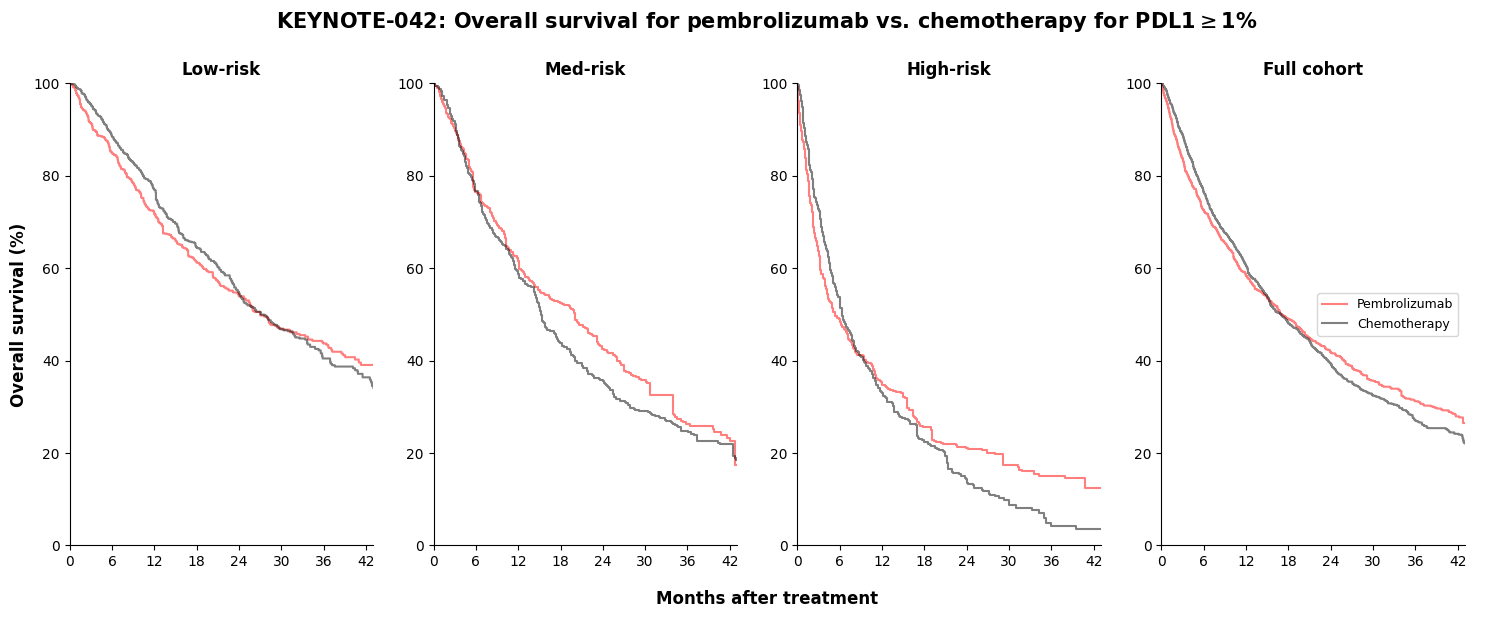

In [172]:
fig = plt.figure(figsize=(18, 6))

# Plot survival curves for low risk group 
plt.subplot(1, 4, 1)

plt.step(kmf_low_pembro_042_iptw.timeline, kmf_low_pembro_042_iptw.survival_function_.values*100, color = 'red', alpha = 0.5)

plt.step(kmf_low_plat_042_iptw.timeline, kmf_low_plat_042_iptw.survival_function_.values*100, color = 'black', alpha = 0.5)

plt.xticks(np.arange(0, 43, 6))
plt.xlim(0, 43)
plt.ylim(0, 100)

plt.title('Low-risk', weight = 'bold')
plt.ylabel('Overall survival (%)', size = 12, weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Plot survival curves for med risk group. 
plt.subplot(1, 4, 2)

plt.step(kmf_med_pembro_042_iptw.timeline, kmf_med_pembro_042_iptw.survival_function_.values*100, color = 'red', alpha = 0.5)

plt.step(kmf_med_plat_042_iptw.timeline, kmf_med_plat_042_iptw.survival_function_.values*100, color = 'black', alpha = 0.5)

plt.xticks(np.arange(0, 43, 6))
plt.xlim(0, 43)
plt.ylim(0, 100)

plt.title('Med-risk', weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Plot survival curves by treatment for high risk group. 
plt.subplot(1, 4, 3)

plt.step(kmf_high_pembro_042_iptw.timeline, kmf_high_pembro_042_iptw.survival_function_.values*100, color = 'red', alpha = 0.5)

plt.step(kmf_high_plat_042_iptw.timeline, kmf_high_plat_042_iptw.survival_function_.values*100, color = 'black', alpha = 0.5)

plt.xticks(np.arange(0, 43, 6))
plt.xlim(0, 43)
plt.ylim(0, 100)

plt.title('High-risk', weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Plot survival curves by treatment for all risk group. 
plt.subplot(1, 4, 4)

plt.step(kmf_all_pembro_042_iptw.timeline, kmf_all_pembro_042_iptw.survival_function_.values*100, color = 'red', alpha = 0.5, label = 'Pembrolizumab')

plt.step(kmf_all_plat_042_iptw.timeline, kmf_all_plat_042_iptw.survival_function_.values*100, color = 'black', alpha = 0.5, label = 'Chemotherapy')

plt.xticks(np.arange(0, 43, 6))
plt.xlim(0, 43)
plt.ylim(0, 100)

plt.title('Full cohort', weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.legend(loc = 'center right', prop = {'size': 9})

fig.add_subplot(1, 1, 1, frameon = False)
plt.tick_params(labelcolor = 'none', which = 'both', top = False, bottom = False, left = False, right = False)
plt.xlabel('Months after treatment', labelpad = 15, size = 12, weight = 'bold')
plt.title(r'KEYNOTE-042: Overall survival for pembrolizumab vs. chemotherapy for PDL1$\geq$1%', pad = 40, size = 15, weight = 'bold')

plt.show()

### KEYNOTE-024: First-line pembrolizumab vs. platinum-based chemotherapy in those with high PDL1 

**INCLUSION CRITERIA**
* Untreated stage IV NSCLC
* Received first line pemobrolizumab or platinum-based chemotherapy 
* PDL1 >= 50% and status known within (-inf, +30] days of start of first-line treatment 
* EGFR and ALK negatve
* No autoimmune diseases in the year preceding metastatic diagnosis 
* No history of ILD, HIV, Hep C, Hep B, severe psychiatric history, or drug use disorder in the year preceding metastatic diagnosis 
* No CNS metastasis at start of treatment 
* ECOG is not 2, 3, or 4 at start of treatment 
* Adeuquate organ function at start of treatment 

#### Pembrolizumab

In [173]:
df_full = pd.read_csv('df_risk_crude.csv', index_col = 'PatientID', dtype = {'death_status': bool})
df_full.index.nunique()

68483

In [174]:
line_therapy = pd.read_csv('LineOfTherapy.csv')

In [175]:
key024_pembro = (
    line_therapy[line_therapy['PatientID'].isin(df_full.index)]
    .query('LineNumber == 1')
    .query('IsMaintenanceTherapy == False')
    .query('LineName == "Pembrolizumab"')
    [['PatientID', 'StartDate']]
)

In [176]:
key024_pembro.loc[:, 'pembro'] = 1

In [177]:
row_ID(key024_pembro)

(3648, 3648)

In [178]:
# Dataframe of all therapies received for those receiving first line pembrolizumab only. 
line_therapy_pembro_024 = (
    line_therapy[line_therapy['PatientID'].isin(key024_pembro.PatientID)])

In [179]:
targeted = [
    'Afatinib',
    'Alectinib',
    'Brigatinib',
    'Cabozantinib',
    'Capmatinib',
    'Ceritinib',
    'Crizotinib',
    'Dabrafenib',
    'Dacomitinib',
    'Entrectinib',
    'Erlotinib',
    'Gefitinib',
    'Lorlatinib',
    'Osimertinib',
    'Pralsetinib',
    'Selpercatinib',
    'Sotorasib',
    'Tepotinib',
    'Trametinib',
    'Vandetanib']

In [180]:
# Patients receiving pembrolizumab therapy who later recieve targeted therapy. 
pembro_024_xcross = (
    line_therapy_pembro_024[line_therapy_pembro_024['LineName'].str.contains('|'.join(targeted))].PatientID)

In [181]:
# Select patients who don't receive targeted therapy in future lines.
key024_pembro = key024_pembro[~key024_pembro['PatientID'].isin(pembro_024_xcross)]

In [182]:
row_ID(key024_pembro)

(3582, 3582)

#### Platinum-based chemotherapy 

In [183]:
line_therapy_fl = (
    line_therapy[line_therapy['PatientID'].isin(df_full.index)]
    .query('LineNumber == 1')
    .query('IsMaintenanceTherapy == False')
)

In [184]:
plat_chemo = [
    'Carboplatin',
    'Cisplatin']

immuno = [
    'Atezolizumab',
    'Cemiplimab',
    'Durvalumab',
    'Ipilimumab',
    'Nivolumab',
    'Pembrolizumab'
]

In [185]:
line_therapy_fl[line_therapy_fl['LineName'].str.contains('|'.join(plat_chemo)) & 
                ~line_therapy_fl['LineName'].str.contains('|'.join(immuno)) &
                ~line_therapy_fl['LineName'].str.contains('|'.join(targeted)) &
                ~line_therapy_fl['LineName'].str.contains('Clinical Study Drug')].LineName.value_counts().head(10)

Carboplatin,Paclitaxel                  8524
Carboplatin,Pemetrexed                  5417
Bevacizumab,Carboplatin,Pemetrexed      2825
Carboplatin,Paclitaxel Protein-Bound    1826
Bevacizumab,Carboplatin,Paclitaxel      1591
Carboplatin,Gemcitabine                 1224
Cisplatin,Etoposide                      793
Carboplatin,Docetaxel                    780
Cisplatin,Pemetrexed                     684
Carboplatin,Etoposide                    363
Name: LineName, dtype: int64

In [186]:
key024_plat = (
    line_therapy_fl[line_therapy_fl['LineName'].str.contains('|'.join(plat_chemo)) & 
                    ~line_therapy_fl['LineName'].str.contains('|'.join(immuno)) &
                    ~line_therapy_fl['LineName'].str.contains('|'.join(targeted)) &
                    ~line_therapy_fl['LineName'].str.contains('Clinical Study Drug')]
    [['PatientID', 'StartDate']]
)

In [187]:
key024_plat.loc[:, 'pembro'] = 0

In [188]:
row_ID(key024_plat)

(25861, 25861)

In [189]:
# Dataframe of all therapies received for those receiving first line platinum regimen  
line_therapy_plat_024 = (
    line_therapy[line_therapy['PatientID'].isin(key024_plat.PatientID)])

In [190]:
# Patients receiving platinum therapy who later recieve targeted therapy. 
plat_024_xcross = (
    line_therapy_plat_024[line_therapy_plat_024['LineName'].str.contains('|'.join(targeted))].PatientID)

In [191]:
# Select patients who don't receive targeted therapy in future lines.
key024_plat = key024_plat[~key024_plat['PatientID'].isin(plat_024_xcross)]

In [192]:
row_ID(key024_plat)

(23800, 23800)

In [193]:
key_024 = pd.concat([key024_pembro, key024_plat])

In [194]:
row_ID(key_024)

(27382, 27382)

In [195]:
key_024 = pd.merge(key_024, df_full, on = 'PatientID', how = 'left')

In [196]:
row_ID(key_024)

(27382, 27382)

In [197]:
key_024['StartDate'] = pd.to_datetime(key_024['StartDate'])

#### High PDL1

In [198]:
biomarkers = pd.read_csv('Enhanced_AdvNSCLCBiomarkers.csv')

In [199]:
biomarkers = biomarkers[biomarkers['PatientID'].isin(key_024['PatientID'])]

In [200]:
biomarkers = pd.merge(biomarkers, key_024[['PatientID', 'StartDate']], on = 'PatientID', how = 'left')

In [201]:
row_ID(biomarkers)

(94603, 19875)

In [202]:
biomarkers['StartDate'] = pd.to_datetime(biomarkers['StartDate'])

In [203]:
biomarkers['ResultDate'] = pd.to_datetime(biomarkers['ResultDate'])

In [204]:
biomarkers['SpecimenReceivedDate'] = pd.to_datetime(biomarkers['SpecimenReceivedDate'])

In [205]:
biomarkers.loc[:, 'result_date'] = (
    np.where(biomarkers['ResultDate'].isna(), biomarkers['SpecimenReceivedDate'], biomarkers['ResultDate'])
)

In [206]:
biomarkers.loc[:, 'date_diff'] = (biomarkers['result_date'] - biomarkers['StartDate']).dt.days

In [207]:
lst = ["50% - 59%", "60% - 69%", "70% - 79%", "80% - 89%", "90% - 99%", "100%"]

pdl1_ids = (
    biomarkers
    .query('BiomarkerName == "PDL1"')
    .query('date_diff <= 30')
    .query('PercentStaining == @lst')
    .PatientID
    .unique()
)

In [208]:
key_024 = key_024[key_024.PatientID.isin(pdl1_ids)]

In [209]:
row_ID(key_024)

(3519, 3519)

#### Time from treatment to death/progression or censor 

In [210]:
mortality_tr = pd.read_csv('mortality_cleaned_tr.csv')

In [211]:
mortality_te = pd.read_csv('mortality_cleaned_te.csv')

In [212]:
mortality_tr = mortality_tr[['PatientID', 'death_date', 'last_activity']]

In [213]:
mortality_te = mortality_te[['PatientID', 'death_date', 'last_activity']]

In [214]:
mortality = pd.concat([mortality_tr, mortality_te], ignore_index = True)
row_ID(mortality)

(68483, 68483)

In [215]:
mortality.loc[:, 'last_activity'] = pd.to_datetime(mortality['last_activity'])

In [216]:
mortality.loc[:, 'death_date'] = pd.to_datetime(mortality['death_date'])

In [217]:
row_ID(mortality)

(68483, 68483)

In [218]:
key_024 = pd.merge(key_024, mortality, on = 'PatientID', how = 'left')

In [219]:
row_ID(key_024)

(3519, 3519)

In [220]:
progression = pd.read_csv('Enhanced_AdvNSCLCProgression.csv')

In [221]:
progression = progression[progression.PatientID.isin(key_024.PatientID)][['PatientID', 'ProgressionDate']]

In [222]:
progression['ProgressionDate'] = pd.to_datetime(progression['ProgressionDate'])

In [223]:
progression = (
    progression
    .sort_values(['PatientID', 'ProgressionDate'], ascending = [True, True])
    .drop_duplicates(subset = 'PatientID', keep = 'first')
)

In [224]:
row_ID(progression)

(3517, 3517)

In [225]:
key_024 = pd.merge(key_024, progression, on = 'PatientID', how = 'left')

In [226]:
row_ID(key_024)

(3519, 3519)

In [227]:
# Percent without progression date in Flaura trial
len(key_024.query('ProgressionDate.isna()', engine = 'python'))/len(key_024)

0.51974992895709

In [228]:
conditions = [
    (key_024.ProgressionDate.notna()),
    ((key_024.ProgressionDate.isna()) & (key_024['death_status'] == 1)),
    ((key_024.ProgressionDate.isna()) & (key_024['death_status'] == 0))]

choices = [
    (key_024['ProgressionDate'] - key_024['StartDate']).dt.days,
    (key_024['death_date'] - key_024['StartDate']).dt.days,
    (key_024['last_activity'] - key_024['StartDate']).dt.days]

key_024.loc[:, 'time_prog_treatment'] = np.select(conditions, choices)

In [229]:
key_024 = key_024.query('time_prog_treatment >= 0')

In [230]:
row_ID(key_024)

(3209, 3209)

In [231]:
conditions = [
    (key_024.ProgressionDate.notna()),
    ((key_024.ProgressionDate.isna()) & (key_024['death_status'] == 1)),
    ((key_024.ProgressionDate.isna()) & (key_024['death_status'] == 0))]

choices = [1, 1, 0]

key_024.loc[:, 'pfs_status'] = np.select(conditions, choices)

#### Patient counts

In [232]:
key_024 = (
    key_024
    .query('stage == "IV"')
    .query('EGFR != "positive"')
    .query('ALK != "positive"')
)

In [233]:
row_ID(key_024)

(2120, 2120)

In [234]:
# Exclude those with autoimmune conditions. 
key_024 = key_024[~key_024['PatientID'].isin(auto_IDs)]

In [235]:
# Exclude those with other relevant comorbidities
key_024 = key_024[~key_024['PatientID'].isin(other_comorb_IDs)]

In [236]:
# Exlcude those with CNS metastasis 
key_024 = key_024[~key_024['PatientID'].isin(cns_fl_IDs)]

In [237]:
# Include those with ECOG 2, 3, or 4 
key_024 = key_024[~key_024['PatientID'].isin(ecog_fl_IDs)]

In [238]:
# Exclude those with abnormal organ function
key_024 = key_024[~key_024['PatientID'].isin(ab_organ_IDs)]

In [239]:
row_ID(key_024)

(1330, 1330)

In [240]:
low_cutoff_024 = cutoff.loc['keynote_024'].low

In [241]:
high_cutoff_024 = cutoff.loc['keynote_024'].high

In [242]:
print('Pembro total:',  key_024.query('pembro == 1').shape[0])
print('High risk:', key_024.query('pembro == 1').query('risk_score >= @high_cutoff_024').shape[0])
print('Med risk:', key_024.query('pembro == 1').query('risk_score < @high_cutoff_024 and risk_score > @low_cutoff_024').shape[0])
print('Low risk:', key_024.query('pembro == 1').query('risk_score <= @low_cutoff_024').shape[0])

Pembro total: 1016
High risk: 230
Med risk: 372
Low risk: 414


In [243]:
print('Platinum total:',  key_024.query('pembro == 0').shape[0])
print('High risk:', key_024.query('pembro == 0').query('risk_score >= @high_cutoff_024').shape[0])
print('Med risk:', key_024.query('pembro == 0').query('risk_score < @high_cutoff_024 and risk_score > @low_cutoff_024').shape[0])
print('Low risk:', key_024.query('pembro == 0').query('risk_score <= @low_cutoff_024').shape[0])

Platinum total: 314
High risk: 89
Med risk: 106
Low risk: 119


#### Survival curves with covariate balancing 

In [244]:
key_024 = key_024.set_index('PatientID')

In [245]:
key_024_iptw = key_024.filter(items = ['pfs_status',
                                       'time_prog_treatment',
                                       'pembro',
                                       'age',
                                       'gender',
                                       'race',
                                       'PracticeType',
                                       'Histology',
                                       'adv_year',
                                       'commercial',
                                       'medicare',
                                       'medicaid',
                                       'ecog_diagnosis',
                                       'risk_score'])

In [246]:
key_024_iptw['met_cat'] = pd.cut(key_024_iptw['adv_year'],
                                 bins = [2010, 2016, float('inf')],
                                 labels = ['11-16', '17-21'])

In [247]:
conditions = [
    ((key_024_iptw['ecog_diagnosis'] == "1.0") | (key_024_iptw['ecog_diagnosis'] == "0.0")),  
    ((key_024_iptw['ecog_diagnosis'] == "2.0") | (key_024_iptw['ecog_diagnosis'] == "3.0"))
]

choices = ['lt_2', 'gte_2']

key_024_iptw['ecog_2'] = np.select(conditions, choices, default = 'unknown')

In [248]:
key_024_iptw.dtypes

pfs_status                int64
time_prog_treatment     float64
pembro                    int64
age                       int64
gender                   object
race                     object
PracticeType             object
Histology                object
adv_year                  int64
commercial              float64
medicare                float64
medicaid                float64
ecog_diagnosis           object
risk_score              float64
met_cat                category
ecog_2                   object
dtype: object

In [249]:
to_be_categorical = list(key_024_iptw.select_dtypes(include = ['object']).columns)

In [250]:
to_be_categorical

['gender', 'race', 'PracticeType', 'Histology', 'ecog_diagnosis', 'ecog_2']

In [251]:
to_be_categorical.append('met_cat')

In [252]:
to_be_categorical.remove('ecog_diagnosis')

In [253]:
# Convert variables in list to categorical.
for x in list(to_be_categorical):
    key_024_iptw[x] = key_024_iptw[x].astype('category')

In [254]:
# List of numeric variables, excluding binary variables. 
numerical_features = ['age']

# Transformer will first calculate column median and impute, and then apply a standard scaler. 
numerical_transformer = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy = 'median')),
    ('std_scaler', StandardScaler())])

In [255]:
# List of categorical features.
categorical_features = list(key_024_iptw.select_dtypes(include = ['category']).columns)

# One-hot-encode categorical features.
categorical_transformer = OneHotEncoder(handle_unknown = 'ignore')

In [256]:
preprocessor = ColumnTransformer(
    transformers = [
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)],
    remainder = 'passthrough')

In [257]:
key_024_iptw_low = (
    key_024_iptw
    .query('risk_score <= @low_cutoff_024')
    .drop(columns = ['risk_score']))

key_024_iptw_med = (
    key_024_iptw
    .query('risk_score < @high_cutoff_024 and risk_score > @low_cutoff_024')
    .drop(columns = ['risk_score']))

key_024_iptw_high = (
    key_024_iptw
    .query('risk_score >= @high_cutoff_024')
    .drop(columns = ['risk_score']))

key_024_iptw_all = (
    key_024_iptw
    .drop(columns = ['risk_score']))

In [258]:
key_024_low_x = preprocessor.fit_transform(key_024_iptw_low.filter(items = ['age',
                                                                            'gender',
                                                                            'race',
                                                                            'PracticeType',
                                                                            'Histology',
                                                                            'met_cat',
                                                                            'commercial',
                                                                            'medicare',
                                                                            'medicaid',
                                                                            'ecog_2']))

key_024_med_x = preprocessor.fit_transform(key_024_iptw_med.filter(items = ['age',
                                                                            'gender',
                                                                            'race',
                                                                            'PracticeType',
                                                                            'Histology',
                                                                            'met_cat',
                                                                            'commercial',
                                                                            'medicare',
                                                                            'medicaid',
                                                                            'ecog_2']))

key_024_high_x = preprocessor.fit_transform(key_024_iptw_high.filter(items = ['age',
                                                                              'gender',
                                                                              'race',
                                                                              'PracticeType',
                                                                              'Histology',
                                                                              'met_cat',
                                                                              'commercial',
                                                                              'medicare',
                                                                              'medicaid',
                                                                              'ecog_2']))

key_024_all_x = preprocessor.fit_transform(key_024_iptw_all.filter(items = ['age',
                                                                            'gender',
                                                                            'race',
                                                                            'PracticeType',
                                                                            'Histology',
                                                                            'met_cat',
                                                                            'commercial',
                                                                            'medicare',
                                                                            'medicaid',
                                                                            'ecog_2']))

In [259]:
lr_024_low = LogisticRegression(max_iter = 1000)
lr_024_low.fit(key_024_low_x, key_024_iptw_low['pembro'])

LogisticRegression(max_iter=1000)

In [260]:
lr_024_med = LogisticRegression(max_iter = 1000)
lr_024_med.fit(key_024_med_x, key_024_iptw_med['pembro'])

LogisticRegression(max_iter=1000)

In [261]:
lr_024_high = LogisticRegression(max_iter = 1000)
lr_024_high.fit(key_024_high_x, key_024_iptw_high['pembro'])

LogisticRegression(max_iter=1000)

In [262]:
lr_024_all = LogisticRegression(max_iter = 1000)
lr_024_all.fit(key_024_all_x, key_024_iptw_all['pembro'])

LogisticRegression(max_iter=1000)

In [263]:
pred_low = lr_024_low.predict_proba(key_024_low_x)
pred_med = lr_024_med.predict_proba(key_024_med_x)
pred_high = lr_024_high.predict_proba(key_024_high_x)
pred_all = lr_024_all.predict_proba(key_024_all_x)

In [264]:
key_024_iptw_low['ps'] = pred_low[:, 1]
key_024_iptw_med['ps'] = pred_med[:, 1]
key_024_iptw_high['ps'] = pred_high[:, 1]
key_024_iptw_all['ps'] = pred_all[:, 1]

In [265]:
key_024_iptw_low['weight'] = (
    np.where(key_024_iptw_low['pembro'] == 1, 1/key_024_iptw_low['ps'], 1/(1 - key_024_iptw_low['ps'])))

key_024_iptw_med['weight'] = (
    np.where(key_024_iptw_med['pembro'] == 1, 1/key_024_iptw_med['ps'], 1/(1 - key_024_iptw_med['ps'])))

key_024_iptw_high['weight'] = (
    np.where(key_024_iptw_high['pembro'] == 1, 1/key_024_iptw_high['ps'], 1/(1 - key_024_iptw_high['ps'])))

key_024_iptw_all['weight'] = (
    np.where(key_024_iptw_all['pembro'] == 1, 1/key_024_iptw_all['ps'], 1/(1 - key_024_iptw_all['ps'])))

In [266]:
# Low KM curves
kmf_low_pembro_024_iptw = KaplanMeierFitter()
kmf_low_plat_024_iptw = KaplanMeierFitter()

kmf_low_pembro_024_iptw.fit(
    key_024_iptw_low.query('pembro == 1').time_prog_treatment/30,
    key_024_iptw_low.query('pembro == 1').pfs_status,
    weights = key_024_iptw_low.query('pembro == 1')['weight'])

kmf_low_plat_024_iptw.fit(
    key_024_iptw_low.query('pembro == 0').time_prog_treatment/30,
    key_024_iptw_low.query('pembro == 0').pfs_status,
    weights = key_024_iptw_low.query('pembro == 0')['weight'])

# Med KM curves
kmf_med_pembro_024_iptw = KaplanMeierFitter()
kmf_med_plat_024_iptw = KaplanMeierFitter()

kmf_med_pembro_024_iptw.fit(
    key_024_iptw_med.query('pembro == 1').time_prog_treatment/30,
    key_024_iptw_med.query('pembro == 1').pfs_status,
    weights = key_024_iptw_med.query('pembro == 1')['weight'])

kmf_med_plat_024_iptw.fit(
    key_024_iptw_med.query('pembro == 0').time_prog_treatment/30,
    key_024_iptw_med.query('pembro == 0').pfs_status,
    weights = key_024_iptw_med.query('pembro == 0')['weight'])

# High KM curves 
kmf_high_pembro_024_iptw = KaplanMeierFitter()
kmf_high_plat_024_iptw = KaplanMeierFitter()

kmf_high_pembro_024_iptw.fit(
    key_024_iptw_high.query('pembro == 1').time_prog_treatment/30,
    key_024_iptw_high.query('pembro == 1').pfs_status,
    weights = key_024_iptw_high.query('pembro == 1')['weight'])

kmf_high_plat_024_iptw.fit(
    key_024_iptw_high.query('pembro == 0').time_prog_treatment/30,
    key_024_iptw_high.query('pembro == 0').pfs_status,
    weights = key_024_iptw_high.query('pembro == 0')['weight'])

# All KM curves 
kmf_all_pembro_024_iptw = KaplanMeierFitter()
kmf_all_plat_024_iptw = KaplanMeierFitter()

kmf_all_pembro_024_iptw.fit(
    key_024_iptw_all.query('pembro == 1').time_prog_treatment/30,
    key_024_iptw_all.query('pembro == 1').pfs_status,
    weights = key_024_iptw_all.query('pembro == 1')['weight'])

kmf_all_plat_024_iptw.fit(
    key_024_iptw_all.query('pembro == 0').time_prog_treatment/30,
    key_024_iptw_all.query('pembro == 0').pfs_status,
    weights = key_024_iptw_all.query('pembro == 0')['weight'])

/Users/xavierorcutt/Dropbox/ist_project/myenv/lib/python3.7/site-packages/lifelines/fitters/kaplan_meier_fitter.py:344: StatisticalWarning: It looks like your weights are not integers, possibly propensity scores then?
  It's important to know that the naive variance estimates of the coefficients are biased. Instead use Monte Carlo to
  estimate the variances. See paper "Variance estimation when using inverse probability of treatment weighting (IPTW) with survival analysis"
  or "Adjusted Kaplan-Meier estimator and log-rank test with inverse probability of treatment weighting for survival data."
                  
  StatisticalWarning,


<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 1317.09 total observations, 298.273 right-censored observations>

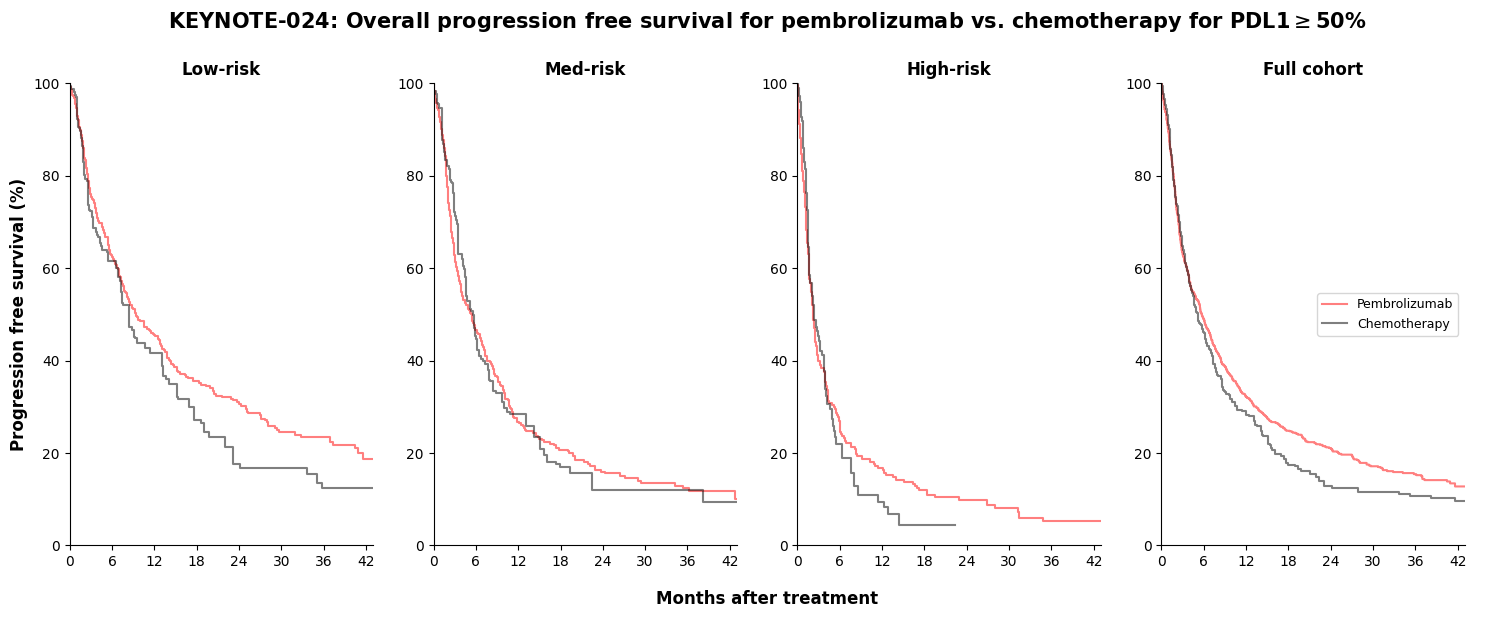

In [267]:
fig = plt.figure(figsize=(18, 6))

# Plot survival curves for low risk group 
plt.subplot(1, 4, 1)

plt.step(kmf_low_pembro_024_iptw.timeline, kmf_low_pembro_024_iptw.survival_function_.values*100, color = 'red', alpha = 0.5)

plt.step(kmf_low_plat_024_iptw.timeline, kmf_low_plat_024_iptw.survival_function_.values*100, color = 'black', alpha = 0.5)

plt.xticks(np.arange(0, 43, 6))
plt.xlim(0, 43)
plt.ylim(0, 100)

plt.title('Low-risk', weight = 'bold')
plt.ylabel('Progression free survival (%)', size = 12, weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Plot survival curves for med risk group. 
plt.subplot(1, 4, 2)

plt.step(kmf_med_pembro_024_iptw.timeline, kmf_med_pembro_024_iptw.survival_function_.values*100, color = 'red', alpha = 0.5)

plt.step(kmf_med_plat_024_iptw.timeline, kmf_med_plat_024_iptw.survival_function_.values*100, color = 'black', alpha = 0.5)

plt.xticks(np.arange(0, 43, 6))
plt.xlim(0, 43)
plt.ylim(0, 100)

plt.title('Med-risk', weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Plot survival curves by treatment for high risk group. 
plt.subplot(1, 4, 3)

plt.step(kmf_high_pembro_024_iptw.timeline, kmf_high_pembro_024_iptw.survival_function_.values*100, color = 'red', alpha = 0.5)

plt.step(kmf_high_plat_024_iptw.timeline, kmf_high_plat_024_iptw.survival_function_.values*100, color = 'black', alpha = 0.5)

plt.xticks(np.arange(0, 43, 6))
plt.xlim(0, 43)
plt.ylim(0, 100)

plt.title('High-risk', weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Plot survival curves by treatment for all risk group. 
plt.subplot(1, 4, 4)

plt.step(kmf_all_pembro_024_iptw.timeline, kmf_all_pembro_024_iptw.survival_function_.values*100, color = 'red', alpha = 0.5, label = 'Pembrolizumab')

plt.step(kmf_all_plat_024_iptw.timeline, kmf_all_plat_024_iptw.survival_function_.values*100, color = 'black', alpha = 0.5, label = 'Chemotherapy')

plt.xticks(np.arange(0, 43, 6))
plt.xlim(0, 43)
plt.ylim(0, 100)

plt.title('Full cohort', weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.legend(loc = 'center right', prop = {'size': 9})

fig.add_subplot(1, 1, 1, frameon = False)
plt.tick_params(labelcolor = 'none', which = 'both', top = False, bottom = False, left = False, right = False)
plt.xlabel('Months after treatment', labelpad = 15, size = 12, weight = 'bold')
plt.title(r'KEYNOTE-024: Overall progression free survival for pembrolizumab vs. chemotherapy for PDL1$\geq$50%', pad = 40, size = 15, weight = 'bold')

plt.show()

### KEYNOTE-189: First-line pembrolizumab plus chemotherapy vs. chemotherapy

**INCLUSION CRITERIA**
* Untreated stage IV NSCLC
* Received first line pemobrolizumab plus platinum-based chemotherapy or platinum-based chemotherapy
* EGFR and ALK negative
* No autoimmune diseases in the year preceding metastatic diagnosis 
* No history of ILD, HIV, Hep C, Hep B, severe psychiatric history, or drug use disorder in the year preceding metastatic diagnosis 
* No CNS metastasis at start of treatment 
* ECOG is not 2, 3, or 4 at start of treatment 
* Adeuquate organ function at start of treatment 

#### Pembrolizumab + chemotherapy 

In [268]:
df_full = pd.read_csv('df_risk_crude.csv', index_col = 'PatientID', dtype = {'death_status': bool})
df_full.index.nunique()

68483

In [269]:
line_therapy = pd.read_csv('LineOfTherapy.csv')

In [270]:
line_therapy[line_therapy['LineName'].str.contains('Pemetrexed')].LineName.value_counts().head(10)

Carboplatin,Pemetrexed                              6700
Carboplatin,Pembrolizumab,Pemetrexed                5113
Pemetrexed                                          4711
Bevacizumab,Carboplatin,Pemetrexed                  3459
Bevacizumab,Pemetrexed                              1569
Pembrolizumab,Pemetrexed                            1554
Cisplatin,Pemetrexed                                 811
Bevacizumab,Cisplatin,Pemetrexed                     174
Abiraterone,Carboplatin,Pembrolizumab,Pemetrexed     100
Bevacizumab-Awwb,Carboplatin,Pemetrexed               82
Name: LineName, dtype: int64

In [271]:
line_therapy_fl = (
    line_therapy[line_therapy['PatientID'].isin(df_full.index)]
    .query('LineNumber == 1')
    .query('IsMaintenanceTherapy == False')
)

In [272]:
plat_chemo = [
    'Carboplatin',
    'Cisplatin']

immuno_wout_pembro = [
    'Atezolizumab',
    'Cemiplimab',
    'Durvalumab',
    'Ipilimumab',
    'Nivolumab']

targeted = [
    'Afatinib',
    'Alectinib',
    'Brigatinib',
    'Cabozantinib',
    'Capmatinib',
    'Ceritinib',
    'Crizotinib',
    'Dabrafenib',
    'Dacomitinib',
    'Entrectinib',
    'Erlotinib',
    'Gefitinib',
    'Lorlatinib',
    'Osimertinib',
    'Pralsetinib',
    'Selpercatinib',
    'Sotorasib',
    'Tepotinib',
    'Trametinib',
    'Vandetanib']

In [273]:
line_therapy_fl[line_therapy_fl['LineName'].str.contains('|'.join(plat_chemo)) & 
                line_therapy_fl['LineName'].str.contains('Pembrolizumab') &
                ~line_therapy_fl['LineName'].str.contains('|'.join(targeted)) &
                ~line_therapy_fl['LineName'].str.contains('|'.join(immuno_wout_pembro)) &
                ~line_therapy_fl['LineName'].str.contains('Clinical Study Drug')].LineName.value_counts().head(10)

Carboplatin,Pembrolizumab,Pemetrexed                     4275
Carboplatin,Paclitaxel,Pembrolizumab                      803
Carboplatin,Paclitaxel Protein-Bound,Pembrolizumab        534
Abiraterone,Carboplatin,Pembrolizumab,Pemetrexed           79
Carboplatin,Cyclophosphamide,Pembrolizumab,Pemetrexed      31
Cisplatin,Pembrolizumab,Pemetrexed                         27
Carboplatin,Pembrolizumab                                  19
Carboplatin,Docetaxel,Pembrolizumab                        18
Carboplatin,Paclitaxel,Pembrolizumab,Pemetrexed            18
Bevacizumab,Carboplatin,Pembrolizumab,Pemetrexed           10
Name: LineName, dtype: int64

In [274]:
key189_pembro = (
    line_therapy_fl[line_therapy_fl['LineName'].str.contains('|'.join(plat_chemo)) & 
                    line_therapy_fl['LineName'].str.contains('Pembrolizumab') &
                    ~line_therapy_fl['LineName'].str.contains('|'.join(targeted)) &
                    ~line_therapy_fl['LineName'].str.contains('|'.join(immuno_wout_pembro)) &
                    ~line_therapy_fl['LineName'].str.contains('Clinical Study Drug')]
    [['PatientID', 'StartDate']]
)

In [275]:
key189_pembro.loc[:, 'pembro'] = 1

In [276]:
row_ID(key189_pembro)

(5878, 5878)

In [277]:
# Dataframe of all therapies received for those receiving first line pembrolizumab only. 
line_therapy_pembro_189 = (
    line_therapy[line_therapy['PatientID'].isin(key189_pembro.PatientID)])

In [278]:
# Patients receiving pembrolizumab therapy who later recieve targeted therapy. 
pembro_189_xcross = (
    line_therapy_pembro_189[line_therapy_pembro_189['LineName'].str.contains('|'.join(targeted))].PatientID)

In [279]:
# Select patients who don't receive targeted therapy in future lines.
key189_pembro = key189_pembro[~key189_pembro['PatientID'].isin(pembro_189_xcross)]

In [280]:
row_ID(key189_pembro)

(5673, 5673)

#### Platinum-based chemotherapy

In [281]:
plat_chemo = [
    'Carboplatin',
    'Cisplatin']

immuno = [
    'Atezolizumab',
    'Cemiplimab',
    'Durvalumab',
    'Ipilimumab',
    'Nivolumab',
    'Pembrolizumab'
]

In [282]:
line_therapy_fl[line_therapy_fl['LineName'].str.contains('|'.join(plat_chemo)) & 
                ~line_therapy_fl['LineName'].str.contains('|'.join(immuno)) &
                ~line_therapy_fl['LineName'].str.contains('|'.join(targeted)) &
                ~line_therapy_fl['LineName'].str.contains('Clinical Study Drug')].LineName.value_counts().head(10)

Carboplatin,Paclitaxel                  8524
Carboplatin,Pemetrexed                  5417
Bevacizumab,Carboplatin,Pemetrexed      2825
Carboplatin,Paclitaxel Protein-Bound    1826
Bevacizumab,Carboplatin,Paclitaxel      1591
Carboplatin,Gemcitabine                 1224
Cisplatin,Etoposide                      793
Carboplatin,Docetaxel                    780
Cisplatin,Pemetrexed                     684
Carboplatin,Etoposide                    363
Name: LineName, dtype: int64

In [283]:
key189_plat = (
    line_therapy_fl[line_therapy_fl['LineName'].str.contains('|'.join(plat_chemo)) & 
                    ~line_therapy_fl['LineName'].str.contains('|'.join(immuno)) &
                    ~line_therapy_fl['LineName'].str.contains('|'.join(targeted)) &
                    ~line_therapy_fl['LineName'].str.contains('Clinical Study Drug')]
    [['PatientID', 'StartDate']]
)

In [284]:
key189_plat.loc[:, 'pembro'] = 0

In [285]:
row_ID(key189_plat)

(25861, 25861)

In [286]:
# Dataframe of all therapies received for those receiving first line platinum regimen 
line_therapy_plat_189 = (
    line_therapy[line_therapy['PatientID'].isin(key189_plat.PatientID)])

In [287]:
# Patients receiving platinum therapy who later recieve targeted therapy
plat_189_xcross = (
    line_therapy_plat_189[line_therapy_plat_189['LineName'].str.contains('|'.join(targeted))].PatientID)

In [288]:
# Select patients who don't receive targeted therapy
key189_plat = key189_plat[~key189_plat['PatientID'].isin(plat_189_xcross)]

In [289]:
row_ID(key189_plat)

(23800, 23800)

In [290]:
key_189 = pd.concat([key189_pembro, key189_plat])

In [291]:
row_ID(key_189)

(29473, 29473)

In [292]:
key_189 = pd.merge(key_189, df_full, on = 'PatientID', how = 'left')

In [293]:
row_ID(key_189)

(29473, 29473)

In [294]:
key_189['StartDate'] = pd.to_datetime(key_189['StartDate'])

#### Time from treatment to death or censor

In [295]:
mortality_tr = pd.read_csv('mortality_cleaned_tr.csv')

In [296]:
mortality_te = pd.read_csv('mortality_cleaned_te.csv')

In [297]:
mortality_tr = mortality_tr[['PatientID', 'death_date', 'last_activity']]

In [298]:
mortality_te = mortality_te[['PatientID', 'death_date', 'last_activity']]

In [299]:
mortality = pd.concat([mortality_tr, mortality_te], ignore_index = True)
print(len(mortality), mortality.PatientID.is_unique)

68483 True


In [300]:
mortality.loc[:, 'last_activity'] = pd.to_datetime(mortality['last_activity'])

In [301]:
mortality.loc[:, 'death_date'] = pd.to_datetime(mortality['death_date'])

In [302]:
key_189 = pd.merge(key_189, mortality, on = 'PatientID', how = 'left')

In [303]:
len(key_189)

29473

In [304]:
conditions = [
    (key_189['death_status'] == 1),
    (key_189['death_status'] == 0)]

choices = [
    (key_189['death_date'] - key_189['StartDate']).dt.days,
    (key_189['last_activity'] - key_189['StartDate']).dt.days]

key_189.loc[:, 'timerisk_treatment'] = np.select(conditions, choices)

In [305]:
key_189 = key_189.query('timerisk_treatment >= 0')

#### Patient count

In [306]:
key_189 = (
    key_189
    .query('Histology == "Non-squamous cell carcinoma"')
    .query('EGFR != "positive"')
    .query('ALK != "positive"')
)

In [307]:
row_ID(key_189)

(19124, 19124)

In [308]:
# Exclude those with autoimmune conditions. 
key_189 = key_189[~key_189['PatientID'].isin(auto_IDs)]

In [309]:
# Exclude those with other relevant comorbidities
key_189 = key_189[~key_189['PatientID'].isin(other_comorb_IDs)]

In [310]:
# Exlcude those with CNS metastasis 
key_189 = key_189[~key_189['PatientID'].isin(cns_fl_IDs)]

In [311]:
# Exclude those with ECOG 2, 3, or 4
key_189 = key_189[~key_189['PatientID'].isin(ecog_fl_IDs)]

In [312]:
# Exclude those with abnormal organ function
key_189 = key_189[~key_189['PatientID'].isin(ab_organ_IDs)]

In [313]:
row_ID(key_189)

(13761, 13761)

In [314]:
low_cutoff_189 = cutoff.loc['keynote_189'].low

In [315]:
high_cutoff_189 = cutoff.loc['keynote_189'].high

In [316]:
print('Pembro + chemo total:',  key_189.query('pembro == 1').shape[0])
print('High risk:', key_189.query('pembro == 1').query('risk_score >= @high_cutoff_189').shape[0])
print('Med risk:', key_189.query('pembro == 1').query('risk_score < @high_cutoff_189 and risk_score > @low_cutoff_189').shape[0])
print('Low risk:', key_189.query('pembro == 1').query('risk_score <= @low_cutoff_189').shape[0])

Pembro + chemo total: 2794
High risk: 749
Med risk: 964
Low risk: 1081


In [317]:
print('Platinum total:',  key_189.query('pembro == 0').shape[0])
print('High risk:', key_189.query('pembro == 0').query('risk_score >= @high_cutoff_189').shape[0])
print('Med risk:', key_189.query('pembro == 0').query('risk_score < @high_cutoff_189 and risk_score > @low_cutoff_189').shape[0])
print('Low risk:', key_189.query('pembro == 0').query('risk_score <= @low_cutoff_189').shape[0])

Platinum total: 10967
High risk: 2694
Med risk: 3637
Low risk: 4636


#### Survival curves with covariate balancing 

In [318]:
key_189 = key_189.set_index('PatientID')

In [319]:
key_189_iptw = key_189.filter(items = ['death_status',
                                       'timerisk_treatment',
                                       'pembro',
                                       'age',
                                       'gender',
                                       'race',
                                       'PracticeType',
                                       'Histology',
                                       'adv_year',
                                       'delta_adv_diagnosis',
                                       'commercial',
                                       'medicare',
                                       'medicaid',
                                       'ecog_diagnosis',
                                       'pdl1',
                                       'risk_score'])

In [320]:
key_189_iptw['met_cat'] = pd.cut(key_189_iptw['adv_year'],
                                 bins = [2010, 2018, float('inf')],
                                 labels = ['11-18', '19-22'])

In [321]:
conditions = [
    ((key_189_iptw['pdl1'] == "1-49%") | (key_189_iptw['pdl1'] == "50-100%"))]

choices = ['>0%']

key_189_iptw['pdl1_cat'] = np.select(conditions, choices, default = key_189_iptw['pdl1'])

In [322]:
conditions = [
    ((key_189_iptw['ecog_diagnosis'] == "1.0") | (key_189_iptw['ecog_diagnosis'] == "0.0")),  
    ((key_189_iptw['ecog_diagnosis'] == "2.0") | (key_189_iptw['ecog_diagnosis'] == "3.0"))
]

choices = ['lt_2', 'gte_2']

key_189_iptw['ecog_2'] = np.select(conditions, choices, default = 'unknown')

In [323]:
key_189_iptw.dtypes

death_status               bool
timerisk_treatment      float64
pembro                    int64
age                       int64
gender                   object
race                     object
PracticeType             object
Histology                object
adv_year                  int64
delta_adv_diagnosis       int64
commercial              float64
medicare                float64
medicaid                float64
ecog_diagnosis           object
pdl1                     object
risk_score              float64
met_cat                category
pdl1_cat                 object
ecog_2                   object
dtype: object

In [324]:
to_be_categorical = list(key_189_iptw.select_dtypes(include = ['object']).columns)

In [325]:
to_be_categorical

['gender',
 'race',
 'PracticeType',
 'Histology',
 'ecog_diagnosis',
 'pdl1',
 'pdl1_cat',
 'ecog_2']

In [326]:
to_be_categorical.append('met_cat')

In [327]:
to_be_categorical.remove('pdl1')

In [328]:
to_be_categorical.remove('ecog_diagnosis')

In [329]:
# Convert variables in list to categorical.
for x in list(to_be_categorical):
    key_189_iptw[x] = key_189_iptw[x].astype('category')

In [330]:
# List of numeric variables, excluding binary variables. 
numerical_features = ['age', 'delta_adv_diagnosis']

# Transformer will first calculate column median and impute, and then apply a standard scaler. 
numerical_transformer = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy = 'median')),
    ('std_scaler', StandardScaler())])

In [331]:
# List of categorical features.
categorical_features = list(key_189_iptw.select_dtypes(include = ['category']).columns)

# One-hot-encode categorical features.
categorical_transformer = OneHotEncoder(handle_unknown = 'ignore')

In [332]:
preprocessor = ColumnTransformer(
    transformers = [
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)],
    remainder = 'passthrough')

In [333]:
key_189_iptw_low = (
    key_189_iptw
    .query('risk_score <= @low_cutoff_189')
    .drop(columns = ['risk_score']))

key_189_iptw_med = (
    key_189_iptw
    .query('risk_score < @high_cutoff_189 and risk_score > @low_cutoff_189')
    .drop(columns = ['risk_score']))

key_189_iptw_high = (
    key_189_iptw
    .query('risk_score >= @high_cutoff_189')
    .drop(columns = ['risk_score']))

key_189_iptw_all = (
    key_189_iptw
    .drop(columns = ['risk_score']))

In [334]:
key_189_low_x = preprocessor.fit_transform(key_189_iptw_low.filter(items = ['age',
                                                                            'gender',
                                                                            'race',
                                                                            'PracticeType',
                                                                            'Histology',
                                                                            'met_cat',
                                                                            'delta_adv_diagnosis',
                                                                            'commercial',
                                                                            'medicare',
                                                                            'medicaid',
                                                                            'ecog_2',
                                                                            'pdl1_cat']))

key_189_med_x = preprocessor.fit_transform(key_189_iptw_med.filter(items = ['age',
                                                                            'gender',
                                                                            'race',
                                                                            'PracticeType',
                                                                            'Histology',
                                                                            'met_cat',
                                                                            'delta_adv_diagnosis',
                                                                            'commercial',
                                                                            'medicare',
                                                                            'medicaid',
                                                                            'ecog_2',
                                                                            'pdl1_cat']))

key_189_high_x = preprocessor.fit_transform(key_189_iptw_high.filter(items = ['age',
                                                                              'gender',
                                                                              'race',
                                                                              'PracticeType',
                                                                              'Histology',
                                                                              'met_cat',
                                                                              'delta_adv_diagnosis',
                                                                              'commercial',
                                                                              'medicare',
                                                                              'medicaid',
                                                                              'ecog_2',
                                                                              'pdl1_cat']))

key_189_all_x = preprocessor.fit_transform(key_189_iptw_all.filter(items = ['age',
                                                                            'gender',
                                                                            'race',
                                                                            'PracticeType',
                                                                            'Histology',
                                                                            'met_cat',
                                                                            'delta_adv_diagnosis',
                                                                            'commercial',
                                                                            'medicare',
                                                                            'medicaid',
                                                                            'ecog_2',
                                                                            'pdl1_cat']))

In [335]:
lr_189_low = LogisticRegression(max_iter = 1000)
lr_189_low.fit(key_189_low_x, key_189_iptw_low['pembro'])

LogisticRegression(max_iter=1000)

In [336]:
lr_189_med = LogisticRegression(max_iter = 1000)
lr_189_med.fit(key_189_med_x, key_189_iptw_med['pembro'])

LogisticRegression(max_iter=1000)

In [337]:
lr_189_high = LogisticRegression(max_iter = 1000)
lr_189_high.fit(key_189_high_x, key_189_iptw_high['pembro'])

LogisticRegression(max_iter=1000)

In [338]:
lr_189_all = LogisticRegression(max_iter = 1000)
lr_189_all.fit(key_189_all_x, key_189_iptw_all['pembro'])

LogisticRegression(max_iter=1000)

In [339]:
pred_low = lr_189_low.predict_proba(key_189_low_x)
pred_med = lr_189_med.predict_proba(key_189_med_x)
pred_high = lr_189_high.predict_proba(key_189_high_x)
pred_all = lr_189_all.predict_proba(key_189_all_x)

In [340]:
key_189_iptw_low['ps'] = pred_low[:, 1]
key_189_iptw_med['ps'] = pred_med[:, 1]
key_189_iptw_high['ps'] = pred_high[:, 1]
key_189_iptw_all['ps'] = pred_all[:, 1]

In [341]:
key_189_iptw_low['weight'] = (
    np.where(key_189_iptw_low['pembro'] == 1, 1/key_189_iptw_low['ps'], 1/(1 - key_189_iptw_low['ps'])))

key_189_iptw_med['weight'] = (
    np.where(key_189_iptw_med['pembro'] == 1, 1/key_189_iptw_med['ps'], 1/(1 - key_189_iptw_med['ps'])))

key_189_iptw_high['weight'] = (
    np.where(key_189_iptw_high['pembro'] == 1, 1/key_189_iptw_high['ps'], 1/(1 - key_189_iptw_high['ps'])))

key_189_iptw_all['weight'] = (
    np.where(key_189_iptw_all['pembro'] == 1, 1/key_189_iptw_all['ps'], 1/(1 - key_189_iptw_all['ps'])))

In [342]:
# Low KM curves
kmf_low_pembro_189_iptw = KaplanMeierFitter()
kmf_low_plat_189_iptw = KaplanMeierFitter()

kmf_low_pembro_189_iptw.fit(
    key_189_iptw_low.query('pembro == 1').timerisk_treatment/30,
    key_189_iptw_low.query('pembro == 1').death_status,
    weights = key_189_iptw_low.query('pembro == 1')['weight'])

kmf_low_plat_189_iptw.fit(
    key_189_iptw_low.query('pembro == 0').timerisk_treatment/30,
    key_189_iptw_low.query('pembro == 0').death_status,
    weights = key_189_iptw_low.query('pembro == 0')['weight'])

# Med KM curves
kmf_med_pembro_189_iptw = KaplanMeierFitter()
kmf_med_plat_189_iptw = KaplanMeierFitter()

kmf_med_pembro_189_iptw.fit(
    key_189_iptw_med.query('pembro == 1').timerisk_treatment/30,
    key_189_iptw_med.query('pembro == 1').death_status,
    weights = key_189_iptw_med.query('pembro == 1')['weight'])

kmf_med_plat_189_iptw.fit(
    key_189_iptw_med.query('pembro == 0').timerisk_treatment/30,
    key_189_iptw_med.query('pembro == 0').death_status,
    weights = key_189_iptw_med.query('pembro == 0')['weight'])

# High KM curves 
kmf_high_pembro_189_iptw = KaplanMeierFitter()
kmf_high_plat_189_iptw = KaplanMeierFitter()

kmf_high_pembro_189_iptw.fit(
    key_189_iptw_high.query('pembro == 1').timerisk_treatment/30,
    key_189_iptw_high.query('pembro == 1').death_status,
    weights = key_189_iptw_high.query('pembro == 1')['weight'])

kmf_high_plat_189_iptw.fit(
    key_189_iptw_high.query('pembro == 0').timerisk_treatment/30,
    key_189_iptw_high.query('pembro == 0').death_status,
    weights = key_189_iptw_high.query('pembro == 0')['weight'])

# All KM curves 
kmf_all_pembro_189_iptw = KaplanMeierFitter()
kmf_all_plat_189_iptw = KaplanMeierFitter()

kmf_all_pembro_189_iptw.fit(
    key_189_iptw_all.query('pembro == 1').timerisk_treatment/30,
    key_189_iptw_all.query('pembro == 1').death_status,
    weights = key_189_iptw_all.query('pembro == 1')['weight'])

kmf_all_plat_189_iptw.fit(
    key_189_iptw_all.query('pembro == 0').timerisk_treatment/30,
    key_189_iptw_all.query('pembro == 0').death_status,
    weights = key_189_iptw_all.query('pembro == 0')['weight'])

/Users/xavierorcutt/Dropbox/ist_project/myenv/lib/python3.7/site-packages/lifelines/fitters/kaplan_meier_fitter.py:344: StatisticalWarning: It looks like your weights are not integers, possibly propensity scores then?
  It's important to know that the naive variance estimates of the coefficients are biased. Instead use Monte Carlo to
  estimate the variances. See paper "Variance estimation when using inverse probability of treatment weighting (IPTW) with survival analysis"
  or "Adjusted Kaplan-Meier estimator and log-rank test with inverse probability of treatment weighting for survival data."
                  
  StatisticalWarning,


<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 14173.5 total observations, 4325.49 right-censored observations>

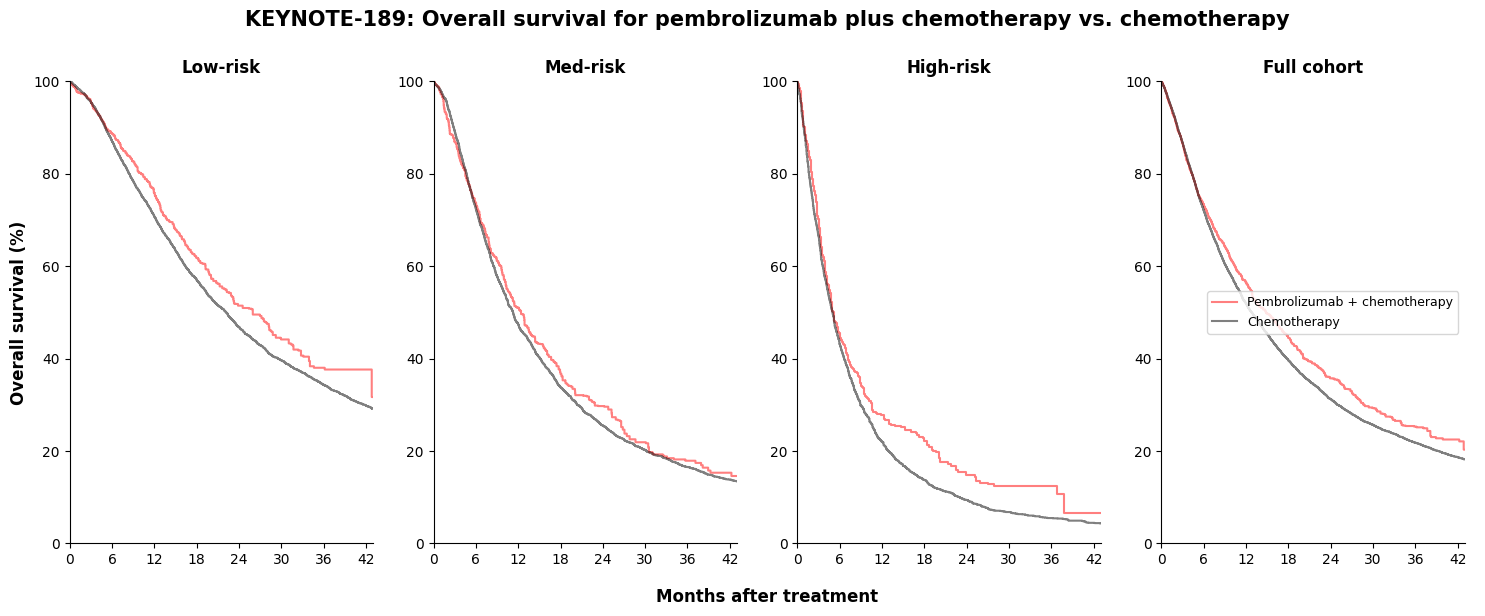

In [343]:
fig = plt.figure(figsize=(18, 6))

# Plot survival curves for low risk group 
plt.subplot(1, 4, 1)

plt.step(kmf_low_pembro_189_iptw.timeline, kmf_low_pembro_189_iptw.survival_function_.values*100, color = 'red', alpha = 0.5)

plt.step(kmf_low_plat_189_iptw.timeline, kmf_low_plat_189_iptw.survival_function_.values*100, color = 'black', alpha = 0.5)

plt.xticks(np.arange(0, 43, 6))
plt.xlim(0, 43)
plt.ylim(0, 100)

plt.title('Low-risk', weight = 'bold')
plt.ylabel('Overall survival (%)', size = 12, weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Plot survival curves for med risk group. 
plt.subplot(1, 4, 2)

plt.step(kmf_med_pembro_189_iptw.timeline, kmf_med_pembro_189_iptw.survival_function_.values*100, color = 'red', alpha = 0.5)

plt.step(kmf_med_plat_189_iptw.timeline, kmf_med_plat_189_iptw.survival_function_.values*100, color = 'black', alpha = 0.5)

plt.xticks(np.arange(0, 43, 6))
plt.xlim(0, 43)
plt.ylim(0, 100)

plt.title('Med-risk', weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Plot survival curves by treatment for high risk group. 
plt.subplot(1, 4, 3)

plt.step(kmf_high_pembro_189_iptw.timeline, kmf_high_pembro_189_iptw.survival_function_.values*100, color = 'red', alpha = 0.5)

plt.step(kmf_high_plat_189_iptw.timeline, kmf_high_plat_189_iptw.survival_function_.values*100, color = 'black', alpha = 0.5)

plt.xticks(np.arange(0, 43, 6))
plt.xlim(0, 43)
plt.ylim(0, 100)

plt.title('High-risk', weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Plot survival curves by treatment for all risk group. 
plt.subplot(1, 4, 4)

plt.step(kmf_all_pembro_189_iptw.timeline, kmf_all_pembro_189_iptw.survival_function_.values*100, color = 'red', alpha = 0.5, label = 'Pembrolizumab + chemotherapy')

plt.step(kmf_all_plat_189_iptw.timeline, kmf_all_plat_189_iptw.survival_function_.values*100, color = 'black', alpha = 0.5, label = 'Chemotherapy')

plt.xticks(np.arange(0, 43, 6))
plt.xlim(0, 43)
plt.ylim(0, 100)

plt.title('Full cohort', weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.legend(loc = 'center right', prop = {'size': 9})

fig.add_subplot(1, 1, 1, frameon = False)
plt.tick_params(labelcolor = 'none', which = 'both', top = False, bottom = False, left = False, right = False)
plt.xlabel('Months after treatment', labelpad = 15, size = 12, weight = 'bold')
plt.title('KEYNOTE-189: Overall survival for pembrolizumab plus chemotherapy vs. chemotherapy', pad = 40, size = 15, weight = 'bold')

plt.show()

### CHECKMATE-078: Second-line nivolumab vs. docetaxel

**INCLUSION CRITERIA**
* Advanced or metastatic NSCLC 
* Progressed on first line platinum-based chemotherapy 
* Received second line nivolumab or docetaxel
* Prior treatments with docetaxel or immunotherapy contraindicated
* EGFR and ALK negative 
* No autoimmune diseases in the year preceding metastatic diagnosis 
* No history of ILD, HIV, Hep C, Hep B, severe psychiatric history, or drug use disorder in the year preceding metastatic diagnosis 
* No CNS metastasis at start of treatment 
* ECOG is not 2, 3, or 4 at start of treatment 

#### Nivolumab 

In [344]:
df_full = pd.read_csv('df_risk_crude.csv', index_col = 'PatientID', dtype = {'death_status': bool})
df_full.index.nunique()

68483

In [345]:
line_therapy = pd.read_csv('LineOfTherapy.csv')

In [346]:
line_therapy_fl = (
    line_therapy[line_therapy.PatientID.isin(df_full.index)]
    .query('LineNumber == 1')
    .query('IsMaintenanceTherapy == False')
)

In [347]:
targeted = [
    'Afatinib',
    'Alectinib',
    'Brigatinib',
    'Cabozantinib',
    'Capmatinib',
    'Ceritinib',
    'Crizotinib',
    'Dabrafenib',
    'Dacomitinib',
    'Entrectinib',
    'Erlotinib',
    'Gefitinib',
    'Lorlatinib',
    'Osimertinib',
    'Pralsetinib',
    'Selpercatinib',
    'Sotorasib',
    'Tepotinib',
    'Trametinib',
    'Vandetanib']

In [348]:
immunotherapy = [
    'Atezolizumab',
    'Cemiplimab',
    'Durvalumab',
    'Ipilimumab',
    'Nivolumab',
    'Pembrolizumab'
]

In [349]:
fl_plat = (
    line_therapy_fl
    [line_therapy_fl['LineName'].str.contains('Carboplatin|Cisplatin')
     & ~line_therapy_fl['LineName'].str.contains('Docetaxel')
     & ~line_therapy_fl['LineName'].str.contains('|'.join(targeted))
     & ~line_therapy_fl['LineName'].str.contains('|'.join(immunotherapy))]
    .PatientID
)

In [350]:
checkmate_nivo = (
    line_therapy[line_therapy.PatientID.isin(fl_plat)]
    .query('LineNumber == 2')
    .query('LineName == "Nivolumab"')
    [['PatientID', 'StartDate']]
)

In [351]:
checkmate_nivo.loc[:, 'nivo'] = 1

In [352]:
row_ID(checkmate_nivo)

(3397, 3397)

#### Docetaxel

In [353]:
checkmate_dotx = (
    line_therapy[line_therapy.PatientID.isin(fl_plat)]
    .query('LineNumber == 2')
    .query('LineName == "Docetaxel"')
    [['PatientID', 'StartDate']]
)

In [354]:
checkmate_dotx.loc[:, 'nivo'] = 0

In [355]:
row_ID(checkmate_dotx)

(745, 745)

In [356]:
checkmate = pd.concat([checkmate_nivo, checkmate_dotx])

In [357]:
row_ID(checkmate)

(4142, 4142)

In [358]:
checkmate = pd.merge(checkmate, df_full, on = 'PatientID', how = 'left')

In [359]:
row_ID(checkmate)

(4142, 4142)

In [360]:
checkmate['StartDate'] = pd.to_datetime(checkmate['StartDate'])

#### Time from treatment to death or censor 

In [361]:
mortality_tr = pd.read_csv('mortality_cleaned_tr.csv')

In [362]:
mortality_te = pd.read_csv('mortality_cleaned_te.csv')

In [363]:
mortality_tr = mortality_tr[['PatientID', 'death_date', 'last_activity']]

In [364]:
mortality_te = mortality_te[['PatientID', 'death_date', 'last_activity']]

In [365]:
mortality = pd.concat([mortality_tr, mortality_te], ignore_index = True)
print(len(mortality), mortality.PatientID.is_unique)

68483 True


In [366]:
mortality.loc[:, 'last_activity'] = pd.to_datetime(mortality['last_activity'])

In [367]:
mortality.loc[:, 'death_date'] = pd.to_datetime(mortality['death_date'])

In [368]:
checkmate = pd.merge(checkmate, mortality, on = 'PatientID', how = 'left')

In [369]:
row_ID(checkmate)

(4142, 4142)

In [370]:
conditions = [
    (checkmate['death_status'] == 1),
    (checkmate['death_status'] == 0)]

choices = [
    (checkmate['death_date'] - checkmate['StartDate']).dt.days,
    (checkmate['last_activity'] - checkmate['StartDate']).dt.days]

checkmate.loc[:, 'timerisk_treatment'] = np.select(conditions, choices)

In [371]:
checkmate = checkmate.query('timerisk_treatment >= 0')

#### Patient count 

In [372]:
checkmate = (
    checkmate
    .query('EGFR != "positive"')
    .query('ALK != "positive"')
)

In [373]:
row_ID(checkmate)

(4073, 4073)

In [374]:
# Exclude those with autoimmune conditions. 
checkmate = checkmate[~checkmate['PatientID'].isin(auto_IDs)]

In [375]:
# Exclude those with other relevant comorbidities
checkmate = checkmate[~checkmate['PatientID'].isin(other_comorb_IDs)]

In [376]:
# Exlcude those with CNS metastasis 
checkmate = checkmate[~checkmate['PatientID'].isin(cns_sec_IDs)]

In [377]:
# Include only those with ECOG 2, 3, or 4 
checkmate = checkmate[~checkmate['PatientID'].isin(ecog_sec_IDs)]

In [378]:
row_ID(checkmate)

(3045, 3045)

In [379]:
low_cutoff_078 = cutoff.loc['checkmate_078'].low

In [380]:
high_cutoff_078 = cutoff.loc['checkmate_078'].high

In [381]:
print('Nivolumab total:',  checkmate.query('nivo == 1').shape[0])
print('High risk:', checkmate.query('nivo == 1').query('risk_score >= @high_cutoff_078').shape[0])
print('Med risk:', checkmate.query('nivo == 1').query('risk_score < @high_cutoff_078 and risk_score > @low_cutoff_078').shape[0])
print('Low risk:', checkmate.query('nivo == 1').query('risk_score <= @low_cutoff_078').shape[0])

Nivolumab total: 2460
High risk: 703
Med risk: 867
Low risk: 890


In [382]:
print('Docetaxel total:',  checkmate.query('nivo == 0').shape[0])
print('High risk:', checkmate.query('nivo == 0').query('risk_score >= @high_cutoff_078').shape[0])
print('Med risk:', checkmate.query('nivo == 0').query('risk_score < @high_cutoff_078 and risk_score > @low_cutoff_078').shape[0])
print('Low risk:', checkmate.query('nivo == 0').query('risk_score <= @low_cutoff_078').shape[0])

Docetaxel total: 585
High risk: 174
Med risk: 202
Low risk: 209


#### Survival curves with covariate balancing 

In [383]:
checkmate = checkmate.set_index('PatientID')

In [384]:
check_iptw = checkmate.filter(items = ['death_status',
                                       'timerisk_treatment',
                                       'nivo',
                                       'age',
                                       'gender',
                                       'race',
                                       'PracticeType',
                                       'Histology',
                                       'adv_year',
                                       'delta_adv_diagnosis',
                                       'commercial',
                                       'medicare',
                                       'medicaid',
                                       'ecog_diagnosis',
                                       'pdl1',
                                       'risk_score'])

In [385]:
check_iptw['met_cat'] = pd.cut(check_iptw['adv_year'],
                               bins = [2010, 2015, float('inf')],
                               labels = ['11-15', '16-20'])

In [386]:
conditions = [
    ((check_iptw['pdl1'] == "1-49%") | (check_iptw['pdl1'] == "50-100%"))]

choices = ['>0%']

check_iptw['pdl1_cat'] = np.select(conditions, choices, default = check_iptw['pdl1'])

In [387]:
conditions = [
    ((check_iptw['ecog_diagnosis'] == "1.0") | (check_iptw['ecog_diagnosis'] == "0.0")),  
    ((check_iptw['ecog_diagnosis'] == "2.0") | (check_iptw['ecog_diagnosis'] == "3.0"))
]

choices = ['lt_2', 'gte_2']

check_iptw['ecog_2'] = np.select(conditions, choices, default = 'unknown')

In [388]:
check_iptw.dtypes

death_status               bool
timerisk_treatment      float64
nivo                      int64
age                       int64
gender                   object
race                     object
PracticeType             object
Histology                object
adv_year                  int64
delta_adv_diagnosis       int64
commercial              float64
medicare                float64
medicaid                float64
ecog_diagnosis           object
pdl1                     object
risk_score              float64
met_cat                category
pdl1_cat                 object
ecog_2                   object
dtype: object

In [389]:
to_be_categorical = list(check_iptw.select_dtypes(include = ['object']).columns)

In [390]:
to_be_categorical

['gender',
 'race',
 'PracticeType',
 'Histology',
 'ecog_diagnosis',
 'pdl1',
 'pdl1_cat',
 'ecog_2']

In [391]:
to_be_categorical.append('met_cat')

In [392]:
to_be_categorical.remove('pdl1')

In [393]:
to_be_categorical.remove('ecog_diagnosis')

In [394]:
# Convert variables in list to categorical.
for x in list(to_be_categorical):
    check_iptw[x] = check_iptw[x].astype('category')

In [395]:
# List of numeric variables, excluding binary variables. 
numerical_features = ['age', 'delta_adv_diagnosis']

# Transformer will first calculate column median and impute, and then apply a standard scaler. 
numerical_transformer = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy = 'median')),
    ('std_scaler', StandardScaler())])

In [396]:
# List of categorical features.
categorical_features = list(check_iptw.select_dtypes(include = ['category']).columns)

# One-hot-encode categorical features.
categorical_transformer = OneHotEncoder(handle_unknown = 'ignore')

In [397]:
preprocessor = ColumnTransformer(
    transformers = [
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)],
    remainder = 'passthrough')

In [398]:
check_iptw_low = (
    check_iptw
    .query('risk_score <= @low_cutoff_078')
    .drop(columns = ['risk_score']))

check_iptw_med = (
    check_iptw
    .query('risk_score < @high_cutoff_078 and risk_score > @low_cutoff_078')
    .drop(columns = ['risk_score']))

check_iptw_high = (
    check_iptw
    .query('risk_score >= @high_cutoff_078')
    .drop(columns = ['risk_score']))

check_iptw_all = (
    check_iptw
    .drop(columns = ['risk_score']))

In [399]:
check_low_x = preprocessor.fit_transform(check_iptw_low.filter(items = ['age',
                                                                        'gender',
                                                                        'race',
                                                                        'PracticeType',
                                                                        'Histology',
                                                                        'met_cat',
                                                                        'delta_adv_diagnosis',
                                                                        'commercial',
                                                                        'medicare',
                                                                        'medicaid',
                                                                        'ecog_2',
                                                                        'pdl1_cat']))

check_med_x = preprocessor.fit_transform(check_iptw_med.filter(items = ['age',
                                                                        'gender',
                                                                        'race',
                                                                        'PracticeType',
                                                                        'Histology',
                                                                        'met_cat',
                                                                        'delta_adv_diagnosis',
                                                                        'commercial',
                                                                        'medicare',
                                                                        'medicaid',
                                                                        'ecog_2',
                                                                        'pdl1_cat']))

check_high_x = preprocessor.fit_transform(check_iptw_high.filter(items = ['age',
                                                                          'gender',
                                                                          'race',
                                                                          'PracticeType',
                                                                          'Histology',
                                                                          'met_cat',
                                                                          'delta_adv_diagnosis',
                                                                          'commercial',
                                                                          'medicare',
                                                                          'medicaid',
                                                                          'ecog_2',
                                                                          'pdl1_cat']))

check_all_x = preprocessor.fit_transform(check_iptw_all.filter(items = ['age',
                                                                        'gender',
                                                                        'race',
                                                                        'PracticeType',
                                                                        'Histology',
                                                                        'met_cat',
                                                                        'delta_adv_diagnosis',
                                                                        'commercial',
                                                                        'medicare',
                                                                        'medicaid',
                                                                        'ecog_2',
                                                                        'pdl1_cat']))

In [400]:
lr_check_low = LogisticRegression(max_iter = 1000)
lr_check_low.fit(check_low_x, check_iptw_low['nivo'])

LogisticRegression(max_iter=1000)

In [401]:
lr_check_med = LogisticRegression(max_iter = 1000)
lr_check_med.fit(check_med_x, check_iptw_med['nivo'])

LogisticRegression(max_iter=1000)

In [402]:
lr_check_high = LogisticRegression(max_iter = 1000)
lr_check_high.fit(check_high_x, check_iptw_high['nivo'])

LogisticRegression(max_iter=1000)

In [403]:
lr_check_all = LogisticRegression(max_iter = 1000)
lr_check_all.fit(check_all_x, check_iptw_all['nivo'])

LogisticRegression(max_iter=1000)

In [404]:
pred_low = lr_check_low.predict_proba(check_low_x)
pred_med = lr_check_med.predict_proba(check_med_x)
pred_high = lr_check_high.predict_proba(check_high_x)
pred_all = lr_check_all.predict_proba(check_all_x)

In [405]:
check_iptw_low['ps'] = pred_low[:, 1]
check_iptw_med['ps'] = pred_med[:, 1]
check_iptw_high['ps'] = pred_high[:, 1]
check_iptw_all['ps'] = pred_all[:, 1]

In [406]:
check_iptw_low['weight'] = (
    np.where(check_iptw_low['nivo'] == 1, 1/check_iptw_low['ps'], 1/(1 - check_iptw_low['ps'])))

check_iptw_med['weight'] = (
    np.where(check_iptw_med['nivo'] == 1, 1/check_iptw_med['ps'], 1/(1 - check_iptw_med['ps'])))

check_iptw_high['weight'] = (
    np.where(check_iptw_high['nivo'] == 1, 1/check_iptw_high['ps'], 1/(1 - check_iptw_high['ps'])))

check_iptw_all['weight'] = (
    np.where(check_iptw_all['nivo'] == 1, 1/check_iptw_all['ps'], 1/(1 - check_iptw_all['ps'])))

In [407]:
# Low KM curves
kmf_low_nivo_check_iptw = KaplanMeierFitter()
kmf_low_dotx_check_iptw = KaplanMeierFitter()

kmf_low_nivo_check_iptw.fit(
    check_iptw_low.query('nivo == 1').timerisk_treatment/30,
    check_iptw_low.query('nivo == 1').death_status,
    weights = check_iptw_low.query('nivo == 1')['weight'])

kmf_low_dotx_check_iptw.fit(
    check_iptw_low.query('nivo == 0').timerisk_treatment/30,
    check_iptw_low.query('nivo == 0').death_status,
    weights = check_iptw_low.query('nivo == 0')['weight'])

# Med KM curves
kmf_med_nivo_check_iptw = KaplanMeierFitter()
kmf_med_dotx_check_iptw = KaplanMeierFitter()

kmf_med_nivo_check_iptw.fit(
    check_iptw_med.query('nivo == 1').timerisk_treatment/30,
    check_iptw_med.query('nivo == 1').death_status,
    weights = check_iptw_med.query('nivo == 1')['weight'])

kmf_med_dotx_check_iptw.fit(
    check_iptw_med.query('nivo == 0').timerisk_treatment/30,
    check_iptw_med.query('nivo == 0').death_status,
    weights = check_iptw_med.query('nivo == 0')['weight'])

# High KM curves 
kmf_high_nivo_check_iptw = KaplanMeierFitter()
kmf_high_dotx_check_iptw = KaplanMeierFitter()

kmf_high_nivo_check_iptw.fit(
    check_iptw_high.query('nivo == 1').timerisk_treatment/30,
    check_iptw_high.query('nivo == 1').death_status,
    weights = check_iptw_high.query('nivo == 1')['weight'])

kmf_high_dotx_check_iptw.fit(
    check_iptw_high.query('nivo == 0').timerisk_treatment/30,
    check_iptw_high.query('nivo == 0').death_status,
    weights = check_iptw_high.query('nivo == 0')['weight'])

# All KM curves 
kmf_all_nivo_check_iptw = KaplanMeierFitter()
kmf_all_dotx_check_iptw = KaplanMeierFitter()

kmf_all_nivo_check_iptw.fit(
    check_iptw_all.query('nivo == 1').timerisk_treatment/30,
    check_iptw_all.query('nivo == 1').death_status,
    weights = check_iptw_all.query('nivo == 1')['weight'])

kmf_all_dotx_check_iptw.fit(
    check_iptw_all.query('nivo == 0').timerisk_treatment/30,
    check_iptw_all.query('nivo == 0').death_status,
    weights = check_iptw_all.query('nivo == 0')['weight'])

/Users/xavierorcutt/Dropbox/ist_project/myenv/lib/python3.7/site-packages/lifelines/fitters/kaplan_meier_fitter.py:344: StatisticalWarning: It looks like your weights are not integers, possibly propensity scores then?
  It's important to know that the naive variance estimates of the coefficients are biased. Instead use Monte Carlo to
  estimate the variances. See paper "Variance estimation when using inverse probability of treatment weighting (IPTW) with survival analysis"
  or "Adjusted Kaplan-Meier estimator and log-rank test with inverse probability of treatment weighting for survival data."
                  
  StatisticalWarning,


<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 3202.56 total observations, 624.666 right-censored observations>

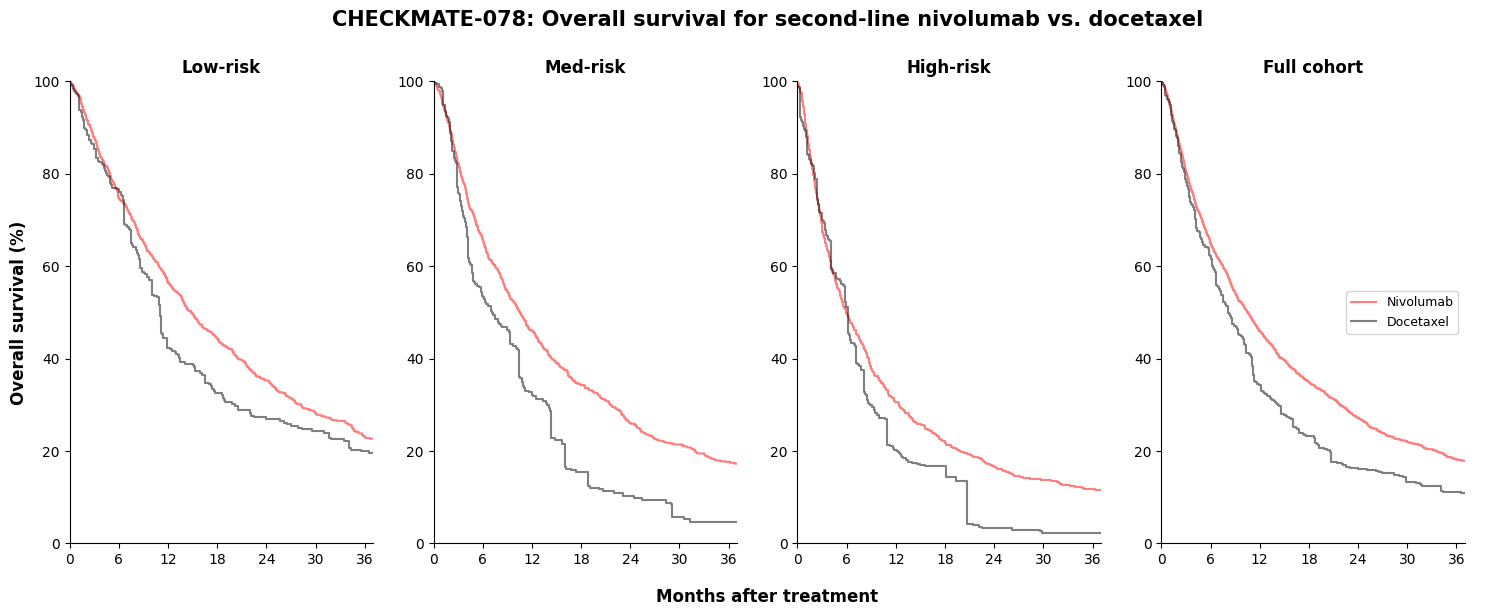

In [408]:
fig = plt.figure(figsize=(18, 6))

# Plot survival curves for low risk group 
plt.subplot(1, 4, 1)

plt.step(kmf_low_nivo_check_iptw.timeline, kmf_low_nivo_check_iptw.survival_function_.values*100, color = 'red', alpha = 0.5)

plt.step(kmf_low_dotx_check_iptw.timeline, kmf_low_dotx_check_iptw.survival_function_.values*100, color = 'black', alpha = 0.5)

plt.xticks(np.arange(0, 37, 6))
plt.xlim(0, 37)
plt.ylim(0, 100)

plt.title('Low-risk', weight = 'bold')
plt.ylabel('Overall survival (%)', size = 12, weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Plot survival curves for med risk group. 
plt.subplot(1, 4, 2)

plt.step(kmf_med_nivo_check_iptw.timeline, kmf_med_nivo_check_iptw.survival_function_.values*100, color = 'red', alpha = 0.5)

plt.step(kmf_med_dotx_check_iptw.timeline, kmf_med_dotx_check_iptw.survival_function_.values*100, color = 'black', alpha = 0.5)

plt.xticks(np.arange(0, 37, 6))
plt.xlim(0, 37)
plt.ylim(0, 100)

plt.title('Med-risk', weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Plot survival curves by treatment for high risk group. 
plt.subplot(1, 4, 3)

plt.step(kmf_high_nivo_check_iptw.timeline, kmf_high_nivo_check_iptw.survival_function_.values*100, color = 'red', alpha = 0.5)

plt.step(kmf_high_dotx_check_iptw.timeline, kmf_high_dotx_check_iptw.survival_function_.values*100, color = 'black', alpha = 0.5)

plt.xticks(np.arange(0, 37, 6))
plt.xlim(0, 37)
plt.ylim(0, 100)

plt.title('High-risk', weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Plot survival curves by treatment for all risk group. 
plt.subplot(1, 4, 4)

plt.step(kmf_all_nivo_check_iptw.timeline, kmf_all_nivo_check_iptw.survival_function_.values*100, color = 'red', alpha = 0.5, label = 'Nivolumab')

plt.step(kmf_all_dotx_check_iptw.timeline, kmf_all_dotx_check_iptw.survival_function_.values*100, color = 'black', alpha = 0.5, label = 'Docetaxel')

plt.xticks(np.arange(0, 37, 6))
plt.xlim(0, 37)
plt.ylim(0, 100)

plt.title('Full cohort', weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.legend(loc = 'center right', prop = {'size': 9})

fig.add_subplot(1, 1, 1, frameon = False)
plt.tick_params(labelcolor = 'none', which = 'both', top = False, bottom = False, left = False, right = False)
plt.xlabel('Months after treatment', labelpad = 15, size = 12, weight = 'bold')
plt.title('CHECKMATE-078: Overall survival for second-line nivolumab vs. docetaxel', pad = 40, size = 15, weight = 'bold')

plt.show()

## FLAURA: osimertinib vs. gefitinib or erlotinib

**INCLUSION CRITERIA**
* Untreated stage IV NSCLC
* Received first line osimertinib or gefitinib or erlotinib
* No autoimmune diseases in the year preceding metastatic diagnosis 
* No history of ILD, HIV, Hep C, Hep B, severe psychiatric history, or drug use disorder in the year preceding metastatic diagnosis 
* No CNS metastasis at start of treatment 
* ECOG is not 2, 3, or 4 at start of treatment 
* Adeuquate organ function at start of treatment 

#### Osimertinib

In [409]:
df_full = pd.read_csv('df_risk_crude.csv', index_col = 'PatientID', dtype = {'death_status': bool})
df_full.index.nunique()

68483

In [410]:
line_therapy = pd.read_csv('LineOfTherapy.csv')

In [411]:
flaura_osim = (
    line_therapy[line_therapy['PatientID'].isin(df_full.index)]
    .query('LineNumber == 1')
    .query('IsMaintenanceTherapy == False')
    .query('LineName == "Osimertinib"')
    [['PatientID', 'StartDate']]
)

In [412]:
flaura_osim.loc[:, 'osim'] = 1

In [413]:
row_ID(flaura_osim)

(1241, 1241)

#### Gefitinib or Erlotinib

In [414]:
flaura_gefer = (
    line_therapy[line_therapy['PatientID'].isin(df_full.index)]
    .query('LineNumber == 1')
    .query('IsMaintenanceTherapy == False')
    .query('LineName == "Gefitinib" or LineName == "Erlotinib"')
    [['PatientID', 'StartDate']]
)

In [415]:
flaura_gefer.loc[:, 'osim'] = 0

In [416]:
row_ID(flaura_gefer)

(3003, 3003)

In [417]:
flaura = pd.concat([flaura_osim, flaura_gefer])

In [418]:
row_ID(flaura)

(4244, 4244)

In [419]:
flaura = pd.merge(flaura, df_full, on = 'PatientID', how = 'left')

In [420]:
row_ID(flaura)

(4244, 4244)

In [421]:
flaura['StartDate'] = pd.to_datetime(flaura['StartDate'])

#### Time from treatment to death/progression or censor 

In [422]:
mortality_tr = pd.read_csv('mortality_cleaned_tr.csv')

In [423]:
mortality_te = pd.read_csv('mortality_cleaned_te.csv')

In [424]:
mortality_tr = mortality_tr[['PatientID', 'death_date', 'last_activity']]

In [425]:
mortality_te = mortality_te[['PatientID', 'death_date', 'last_activity']]

In [426]:
mortality = pd.concat([mortality_tr, mortality_te], ignore_index = True)
row_ID(mortality)

(68483, 68483)

In [427]:
mortality.loc[:, 'last_activity'] = pd.to_datetime(mortality['last_activity'])

In [428]:
mortality.loc[:, 'death_date'] = pd.to_datetime(mortality['death_date'])

In [429]:
row_ID(mortality)

(68483, 68483)

In [430]:
flaura = pd.merge(flaura, mortality, on = 'PatientID', how = 'left')

In [431]:
row_ID(flaura)

(4244, 4244)

In [432]:
progression = pd.read_csv('Enhanced_AdvNSCLCProgression.csv')

In [433]:
progression = progression[progression.PatientID.isin(flaura.PatientID)][['PatientID', 'ProgressionDate']]

In [434]:
progression['ProgressionDate'] = pd.to_datetime(progression['ProgressionDate'])

In [435]:
progression = (
    progression
    .sort_values(['PatientID', 'ProgressionDate'], ascending = [True, True])
    .drop_duplicates(subset = 'PatientID', keep = 'first')
)

In [436]:
row_ID(progression)

(4243, 4243)

In [437]:
flaura = pd.merge(flaura, progression, on = 'PatientID', how = 'left')

In [438]:
row_ID(flaura)

(4244, 4244)

In [439]:
# Percent without progression date in Flaura trial
len(flaura.query('ProgressionDate.isna()', engine = 'python'))/len(flaura)

0.3437794533459001

In [440]:
conditions = [
    (flaura.ProgressionDate.notna()),
    ((flaura.ProgressionDate.isna()) & (flaura['death_status'] == 1)),
    ((flaura.ProgressionDate.isna()) & (flaura['death_status'] == 0))]

choices = [
    (flaura['ProgressionDate'] - flaura['StartDate']).dt.days,
    (flaura['death_date'] - flaura['StartDate']).dt.days,
    (flaura['last_activity'] - flaura['StartDate']).dt.days]

flaura.loc[:, 'time_prog_treatment'] = np.select(conditions, choices)

In [441]:
flaura = flaura.query('time_prog_treatment >= 0')

In [442]:
row_ID(flaura)

(3622, 3622)

In [443]:
conditions = [
    (flaura.ProgressionDate.notna()),
    ((flaura.ProgressionDate.isna()) & (flaura['death_status'] == 1)),
    ((flaura.ProgressionDate.isna()) & (flaura['death_status'] == 0))]

choices = [1, 1, 0]

flaura.loc[:, 'pfs_status'] = np.select(conditions, choices)

#### Patient count

In [444]:
row_ID(flaura)

(3622, 3622)

In [445]:
# Exclude those with autoimmune conditions. 
flaura = flaura[~flaura['PatientID'].isin(auto_IDs)]

In [446]:
# Exclude those with other relevant comorbidities
flaura = flaura[~flaura['PatientID'].isin(other_comorb_IDs)]

In [447]:
# Exlcude those with CNS metastasis 
flaura = flaura[~flaura['PatientID'].isin(cns_fl_IDs)]

In [448]:
# Exclude those with ECOG 2, 3, or 4
flaura = flaura[~flaura['PatientID'].isin(ecog_fl_IDs)]

In [449]:
# Exclude those with abnormal organ function
flaura = flaura[~flaura['PatientID'].isin(ab_organ_IDs)]

In [450]:
row_ID(flaura)

(2725, 2725)

In [451]:
low_cutoff_fl = cutoff.loc['flaura'].low

In [452]:
high_cutoff_fl = cutoff.loc['flaura'].high

In [453]:
print('Osimertinib total:', flaura.query('osim == 1').shape[0])
print('High risk:', flaura.query('osim == 1').query('risk_score >= @high_cutoff_fl').shape[0])
print('Med risk:', flaura.query('osim == 1').query('risk_score < @high_cutoff_fl and risk_score > @low_cutoff_fl').shape[0])
print('Low risk:', flaura.query('osim == 1').query('risk_score <= @low_cutoff_fl').shape[0])

Osimertinib total: 751
High risk: 159
Med risk: 234
Low risk: 358


In [454]:
print('Gefitinib or Erlotinib total:', flaura.query('osim == 0').shape[0])
print('High risk:', flaura.query('osim == 0').query('risk_score >= @high_cutoff_fl').shape[0])
print('Med risk:', flaura.query('osim == 0').query('risk_score < @high_cutoff_fl and risk_score > @low_cutoff_fl').shape[0])
print('Low risk:', flaura.query('osim == 0').query('risk_score <= @low_cutoff_fl').shape[0])

Gefitinib or Erlotinib total: 1974
High risk: 579
Med risk: 725
Low risk: 670


#### PFS with covariate balancing 

In [455]:
flaura = flaura.set_index('PatientID')

In [456]:
flaura['pfs_status'] = flaura['pfs_status'].astype('bool')

In [457]:
flaura_iptw = flaura.filter(items = ['pfs_status',
                                     'time_prog_treatment',
                                     'osim',
                                     'age',
                                     'gender',
                                     'race',
                                     'PracticeType',
                                     'adv_year',
                                     'delta_adv_diagnosis',
                                     'commercial',
                                     'medicare',
                                     'medicaid',
                                     'ecog_diagnosis',
                                     'risk_score'])

In [458]:
flaura_iptw['met_cat'] = pd.cut(flaura_iptw['adv_year'],
                                bins = [2010, 2018, float('inf')],
                                labels = ['11-18', '19-21'])

In [459]:
conditions = [
    ((flaura_iptw['ecog_diagnosis'] == "1.0") | (flaura_iptw['ecog_diagnosis'] == "0.0")),  
    ((flaura_iptw['ecog_diagnosis'] == "2.0") | (flaura_iptw['ecog_diagnosis'] == "3.0"))
]

choices = ['lt_2', 'gte_2']

flaura_iptw['ecog_2'] = np.select(conditions, choices, default = 'unknown')

In [460]:
flaura_iptw.dtypes

pfs_status                 bool
time_prog_treatment     float64
osim                      int64
age                       int64
gender                   object
race                     object
PracticeType             object
adv_year                  int64
delta_adv_diagnosis       int64
commercial              float64
medicare                float64
medicaid                float64
ecog_diagnosis           object
risk_score              float64
met_cat                category
ecog_2                   object
dtype: object

In [461]:
to_be_categorical = list(flaura_iptw.select_dtypes(include = ['object']).columns)

In [462]:
to_be_categorical

['gender', 'race', 'PracticeType', 'ecog_diagnosis', 'ecog_2']

In [463]:
to_be_categorical.append('met_cat')

In [464]:
to_be_categorical.remove('ecog_diagnosis')

In [465]:
# Convert variables in list to categorical.
for x in list(to_be_categorical):
    flaura_iptw[x] = flaura_iptw[x].astype('category')

In [466]:
# List of numeric variables, excluding binary variables. 
numerical_features = ['age', 'delta_adv_diagnosis']

# Transformer will first calculate column median and impute, and then apply a standard scaler. 
numerical_transformer = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy = 'median')),
    ('std_scaler', StandardScaler())])

In [467]:
# List of categorical features.
categorical_features = list(flaura_iptw.select_dtypes(include = ['category']).columns)

# One-hot-encode categorical features.
categorical_transformer = OneHotEncoder(handle_unknown = 'ignore')

In [468]:
preprocessor = ColumnTransformer(
    transformers = [
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)],
    remainder = 'passthrough')

In [469]:
flaura_iptw_low = (
    flaura_iptw
    .query('risk_score <= @low_cutoff_fl')
    .drop(columns = ['risk_score']))

flaura_iptw_med = (
    flaura_iptw
    .query('risk_score < @high_cutoff_fl and risk_score > @low_cutoff_fl')
    .drop(columns = ['risk_score']))

flaura_iptw_high = (
    flaura_iptw
    .query('risk_score >= @high_cutoff_fl')
    .drop(columns = ['risk_score']))

flaura_iptw_all = (
    flaura_iptw
    .drop(columns = ['risk_score']))

In [470]:
flaura_low_x = preprocessor.fit_transform(flaura_iptw_low.filter(items = ['age',
                                                                          'gender',
                                                                          'race',
                                                                          'PracticeType',
                                                                          'met_cat',
                                                                          'delta_adv_diagnosis',
                                                                          'commercial',
                                                                          'medicare',
                                                                          'medicaid',
                                                                          'ecog_2']))

flaura_med_x = preprocessor.fit_transform(flaura_iptw_med.filter(items = ['age',
                                                                          'gender',
                                                                          'race',
                                                                          'PracticeType',
                                                                          'met_cat',
                                                                          'delta_adv_diagnosis',
                                                                          'commercial',
                                                                          'medicare',
                                                                          'medicaid',
                                                                          'ecog_2']))

flaura_high_x = preprocessor.fit_transform(flaura_iptw_high.filter(items = ['age',
                                                                            'gender',
                                                                            'race',
                                                                            'PracticeType',
                                                                            'met_cat',
                                                                            'delta_adv_diagnosis',
                                                                            'commercial',
                                                                            'medicare',
                                                                            'medicaid',
                                                                            'ecog_2']))

flaura_all_x = preprocessor.fit_transform(flaura_iptw_all.filter(items = ['age',
                                                                          'gender',
                                                                          'race',
                                                                          'PracticeType',
                                                                          'met_cat',
                                                                          'delta_adv_diagnosis',
                                                                          'commercial',
                                                                          'medicare',
                                                                          'medicaid',
                                                                          'ecog_2']))

In [471]:
lr_flaura_low = LogisticRegression(max_iter = 1000)
lr_flaura_low.fit(flaura_low_x, flaura_iptw_low['osim'])

LogisticRegression(max_iter=1000)

In [472]:
lr_flaura_med = LogisticRegression(max_iter = 1000)
lr_flaura_med.fit(flaura_med_x, flaura_iptw_med['osim'])

LogisticRegression(max_iter=1000)

In [473]:
lr_flaura_high = LogisticRegression(max_iter = 1000)
lr_flaura_high.fit(flaura_high_x, flaura_iptw_high['osim'])

LogisticRegression(max_iter=1000)

In [474]:
lr_flaura_all = LogisticRegression(max_iter = 1000)
lr_flaura_all.fit(flaura_all_x, flaura_iptw_all['osim'])

LogisticRegression(max_iter=1000)

In [475]:
pred_low = lr_flaura_low.predict_proba(flaura_low_x)
pred_med = lr_flaura_med.predict_proba(flaura_med_x)
pred_high = lr_flaura_high.predict_proba(flaura_high_x)
pred_all = lr_flaura_all.predict_proba(flaura_all_x)

In [476]:
flaura_iptw_low['ps'] = pred_low[:, 1]
flaura_iptw_med['ps'] = pred_med[:, 1]
flaura_iptw_high['ps'] = pred_high[:, 1]
flaura_iptw_all['ps'] = pred_all[:, 1]

In [477]:
flaura_iptw_low['weight'] = (
    np.where(flaura_iptw_low['osim'] == 1, 1/flaura_iptw_low['ps'], 1/(1 - flaura_iptw_low['ps'])))

flaura_iptw_med['weight'] = (
    np.where(flaura_iptw_med['osim'] == 1, 1/flaura_iptw_med['ps'], 1/(1 - flaura_iptw_med['ps'])))

flaura_iptw_high['weight'] = (
    np.where(flaura_iptw_high['osim'] == 1, 1/flaura_iptw_high['ps'], 1/(1 - flaura_iptw_high['ps'])))

flaura_iptw_all['weight'] = (
    np.where(flaura_iptw_all['osim'] == 1, 1/flaura_iptw_all['ps'], 1/(1 - flaura_iptw_all['ps'])))

In [478]:
# Low KM curves
kmf_low_osim_flaura_iptw_pfs = KaplanMeierFitter()
kmf_low_gefer_flaura_iptw_pfs = KaplanMeierFitter()

kmf_low_osim_flaura_iptw_pfs.fit(
    flaura_iptw_low.query('osim == 1').time_prog_treatment/30,
    flaura_iptw_low.query('osim == 1').pfs_status,
    weights = flaura_iptw_low.query('osim == 1')['weight'])

kmf_low_gefer_flaura_iptw_pfs.fit(
    flaura_iptw_low.query('osim == 0').time_prog_treatment/30,
    flaura_iptw_low.query('osim == 0').pfs_status,
    weights = flaura_iptw_low.query('osim == 0')['weight'])

# Med KM curves
kmf_med_osim_flaura_iptw_pfs = KaplanMeierFitter()
kmf_med_gefer_flaura_iptw_pfs = KaplanMeierFitter()

kmf_med_osim_flaura_iptw_pfs.fit(
    flaura_iptw_med.query('osim == 1').time_prog_treatment/30,
    flaura_iptw_med.query('osim == 1').pfs_status,
    weights = flaura_iptw_med.query('osim == 1')['weight'])

kmf_med_gefer_flaura_iptw_pfs.fit(
    flaura_iptw_med.query('osim == 0').time_prog_treatment/30,
    flaura_iptw_med.query('osim == 0').pfs_status,
    weights = flaura_iptw_med.query('osim == 0')['weight'])

# High KM curves 
kmf_high_osim_flaura_iptw_pfs = KaplanMeierFitter()
kmf_high_gefer_flaura_iptw_pfs = KaplanMeierFitter()

kmf_high_osim_flaura_iptw_pfs.fit(
    flaura_iptw_high.query('osim == 1').time_prog_treatment/30,
    flaura_iptw_high.query('osim == 1').pfs_status,
    weights = flaura_iptw_high.query('osim == 1')['weight'])

kmf_high_gefer_flaura_iptw_pfs.fit(
    flaura_iptw_high.query('osim == 0').time_prog_treatment/30,
    flaura_iptw_high.query('osim == 0').pfs_status,
    weights = flaura_iptw_high.query('osim == 0')['weight'])

# All KM curves 
kmf_all_osim_flaura_iptw_pfs = KaplanMeierFitter()
kmf_all_gefer_flaura_iptw_pfs = KaplanMeierFitter()

kmf_all_osim_flaura_iptw_pfs.fit(
    flaura_iptw_all.query('osim == 1').time_prog_treatment/30,
    flaura_iptw_all.query('osim == 1').pfs_status,
    weights = flaura_iptw_all.query('osim == 1')['weight'])

kmf_all_gefer_flaura_iptw_pfs.fit(
    flaura_iptw_all.query('osim == 0').time_prog_treatment/30,
    flaura_iptw_all.query('osim == 0').pfs_status,
    weights = flaura_iptw_all.query('osim == 0')['weight'])

/Users/xavierorcutt/Dropbox/ist_project/myenv/lib/python3.7/site-packages/lifelines/fitters/kaplan_meier_fitter.py:344: StatisticalWarning: It looks like your weights are not integers, possibly propensity scores then?
  It's important to know that the naive variance estimates of the coefficients are biased. Instead use Monte Carlo to
  estimate the variances. See paper "Variance estimation when using inverse probability of treatment weighting (IPTW) with survival analysis"
  or "Adjusted Kaplan-Meier estimator and log-rank test with inverse probability of treatment weighting for survival data."
                  
  StatisticalWarning,


<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 2666.04 total observations, 392.539 right-censored observations>

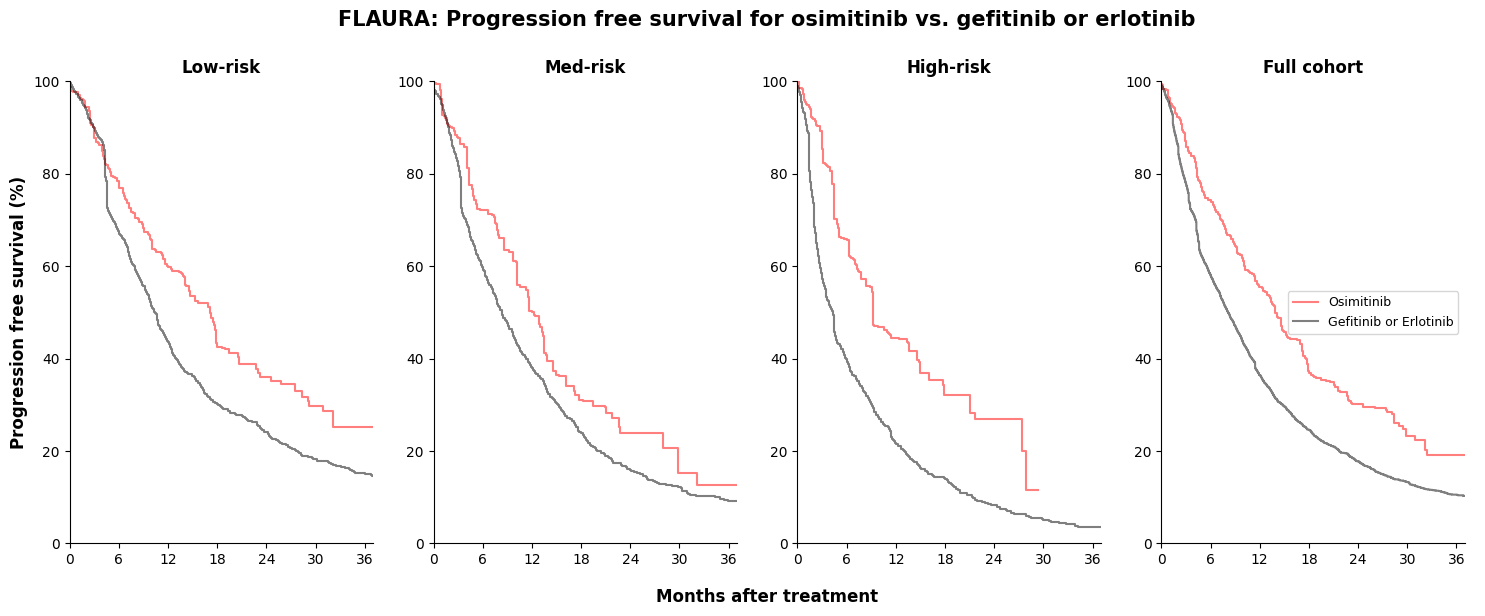

In [479]:
fig = plt.figure(figsize=(18, 6))

# Plot survival curves for low risk group 
plt.subplot(1, 4, 1)

plt.step(kmf_low_osim_flaura_iptw_pfs.timeline, kmf_low_osim_flaura_iptw_pfs.survival_function_.values*100, color = 'red', alpha = 0.5)

plt.step(kmf_low_gefer_flaura_iptw_pfs.timeline, kmf_low_gefer_flaura_iptw_pfs.survival_function_.values*100, color = 'black', alpha = 0.5)

plt.xticks(np.arange(0, 37, 6))
plt.xlim(0, 37)
plt.ylim(0, 100)

plt.title('Low-risk', weight = 'bold')
plt.ylabel('Progression free survival (%)', size = 12, weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Plot survival curves for med risk group. 
plt.subplot(1, 4, 2)

plt.step(kmf_med_osim_flaura_iptw_pfs.timeline, kmf_med_osim_flaura_iptw_pfs.survival_function_.values*100, color = 'red', alpha = 0.5)

plt.step(kmf_med_gefer_flaura_iptw_pfs.timeline, kmf_med_gefer_flaura_iptw_pfs.survival_function_.values*100, color = 'black', alpha = 0.5)

plt.xticks(np.arange(0, 37, 6))
plt.xlim(0, 37)
plt.ylim(0, 100)

plt.title('Med-risk', weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Plot survival curves by treatment for high risk group. 
plt.subplot(1, 4, 3)

plt.step(kmf_high_osim_flaura_iptw_pfs.timeline, kmf_high_osim_flaura_iptw_pfs.survival_function_.values*100, color = 'red', alpha = 0.5)

plt.step(kmf_high_gefer_flaura_iptw_pfs.timeline, kmf_high_gefer_flaura_iptw_pfs.survival_function_.values*100, color = 'black', alpha = 0.5)

plt.xticks(np.arange(0, 37, 6))
plt.xlim(0, 37)
plt.ylim(0, 100)

plt.title('High-risk', weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Plot survival curves by treatment for all risk group. 
plt.subplot(1, 4, 4)

plt.step(kmf_all_osim_flaura_iptw_pfs.timeline, kmf_all_osim_flaura_iptw_pfs.survival_function_.values*100, color = 'red', alpha = 0.5, label = 'Osimitinib')

plt.step(kmf_all_gefer_flaura_iptw_pfs.timeline, kmf_all_gefer_flaura_iptw_pfs.survival_function_.values*100, color = 'black', alpha = 0.5, label = 'Gefitinib or Erlotinib')

plt.xticks(np.arange(0, 37, 6))
plt.xlim(0, 37)
plt.ylim(0, 100)

plt.title('Full cohort', weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.legend(loc = 'center right', prop = {'size': 9})

fig.add_subplot(1, 1, 1, frameon = False)
plt.tick_params(labelcolor = 'none', which = 'both', top = False, bottom = False, left = False, right = False)
plt.xlabel('Months after treatment', labelpad = 15, size = 12, weight = 'bold')
plt.title('FLAURA: Progression free survival for osimitinib vs. gefitinib or erlotinib', pad = 40, size = 15, weight = 'bold')

plt.show()